<a href="https://colab.research.google.com/github/Akshidha-Unni/Osteoporosis-Image-Classification-using-SAM-and-Transfer-Learning/blob/main/Osteoporosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Knee Osteoporosis Multi-Class Classification

The following notebook uses Osteoporosis Knee Classigication dataset which is a publically available on [Kaggle.com](https://www.kaggle.com/datasets/mohamedgobara/osteoporosis-database). The notebook is structured as follows:

1. Loading the dataset
2. Data pre-processing
3. Image Construction and Augmentation
4. Transfer Learning Without SAM
5. Transfer Learning With SAM
6. Prediction
7. Evaluation
8. Results
9. Conclusion

In [ ]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shutil
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models, optimizers
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

#Without SAM

In [ ]:
# Configuration Parameters
DATA_DIR_BIN = 'drive/MyDrive/Osteoporosis_Dataset'
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
EPOCHS = 50
PATIENCE = 10

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Original dataset directory
# DATA_DIR_BIN = '/path/to/dataset'
CLASSES = ['Normal', 'Osteoporosis']  # Class folder names

# Destination directories for splits
BASE_DIR = 'drive/MyDrive/Osteoporosis_Dataset/Split'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Create directories
for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(split_dir, exist_ok=True)
    for class_name in CLASSES:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Split and move files
for class_name in CLASSES:
    class_dir = os.path.join(DATA_DIR_BIN, class_name)
    images = os.listdir(class_dir)
    train, temp = train_test_split(images, test_size=0.4, random_state=42)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    # Move files
    for img in train:
        shutil.copy(os.path.join(class_dir, img), os.path.join(TRAIN_DIR, class_name))
    for img in val:
        shutil.copy(os.path.join(class_dir, img), os.path.join(VAL_DIR, class_name))
    for img in test:
        shutil.copy(os.path.join(class_dir, img), os.path.join(TEST_DIR, class_name))


In [ ]:
healthy_dirs = [r'drive/MyDrive/Osteoporosis_Dataset/Normal']


osteoporosis_dirs = [r'drive/MyDrive/Osteoporosis_Dataset/Osteoporosis']

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Normal', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())

                                           filepaths  labels
0  drive/MyDrive/Osteoporosis_Dataset/Normal/Norm...  Normal
1  drive/MyDrive/Osteoporosis_Dataset/Normal/Norm...  Normal
2  drive/MyDrive/Osteoporosis_Dataset/Normal/Norm...  Normal
3  drive/MyDrive/Osteoporosis_Dataset/Normal/Norm...  Normal
4  drive/MyDrive/Osteoporosis_Dataset/Normal/Norm...  Normal
labels
Normal          614
Osteoporosis    607
Name: count, dtype: int64


In [ ]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(976, 2)
(367, 2)
(245, 2)
(854, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 976 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Found 245 validated image filenames belonging to 2 classes.


####Image Generation and Augmentation

In [ ]:
Data generators
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Split into training and validation
)
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = image_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=4,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
    # subset='training'
)
validation_generator = image_gen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=4,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
    # subset='validation'
)
test_generator = image_gen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=4,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 732 images belonging to 2 classes.
Found 244 images belonging to 2 classes.
Found 245 images belonging to 2 classes.


##DenseNet

In [ ]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Load DenseNet201 as the backbone
densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Freeze the initial layers
for layer in densenet_model.layers:
    layer.trainable = False

# Add custom layers
x = densenet_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model = Model(inputs=densenet_model.input, outputs=output)

# Unfreeze the last 50 layers for fine-tuning
for layer in densenet_model.layers[-50:]:
    layer.trainable = True

# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Add label smoothing
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_10         │ (None, 250, 250, 3)    │              0 │ input_layer_17[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 122, 122, 64)   │          9,408 │ zero_padding2d_10[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 122, 122, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 122, 122, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_11         │ (None, 124, 124, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 61, 61, 64)     │              0 │ zero_padding2d_11[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 61, 61, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 61, 61, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 61, 61, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 61, 61, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 61, 61, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 61, 61, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 20,821,058 (79.43 MB)

 Trainable params: 4,387,010 (16.74 MB)

 Non-trainable params: 16,434,048 (62.69 MB)

In [ ]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 76s 138ms/step - accuracy: 0.6041 - loss: 18.4982 - val_accuracy: 0.7510 - val_loss: 13.3370
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.6924 - loss: 12.9510 - val_accuracy: 0.7755 - val_loss: 11.5743
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7119 - loss: 11.4214 - val_accuracy: 0.8163 - val_loss: 10.8096
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.7632 - loss: 10.7500 - val_accuracy: 0.7796 - val_loss: 10.4648
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.7556 - loss: 10.3026 - val_accuracy: 0.7388 - val_loss: 10.1180
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.7831 - loss: 9.9077 - val_accuracy: 0.8163 - val_loss: 9.6663
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.7747 - loss: 9.5763 - val_accuracy: 0.7714 - val_loss: 9.3433
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.7526 - loss

In [ ]:
model.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.8666 - loss: 8.2640


[8.282388687133789, 0.8528610467910767]

In [ ]:
y_pred_v = model.predict(test)
y_pred_classes_v = np.argmax(y_pred_v, axis=1)
y_true = test.classes

92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 175ms/step


Text(95.72222222222221, 0.5, 'True Label')

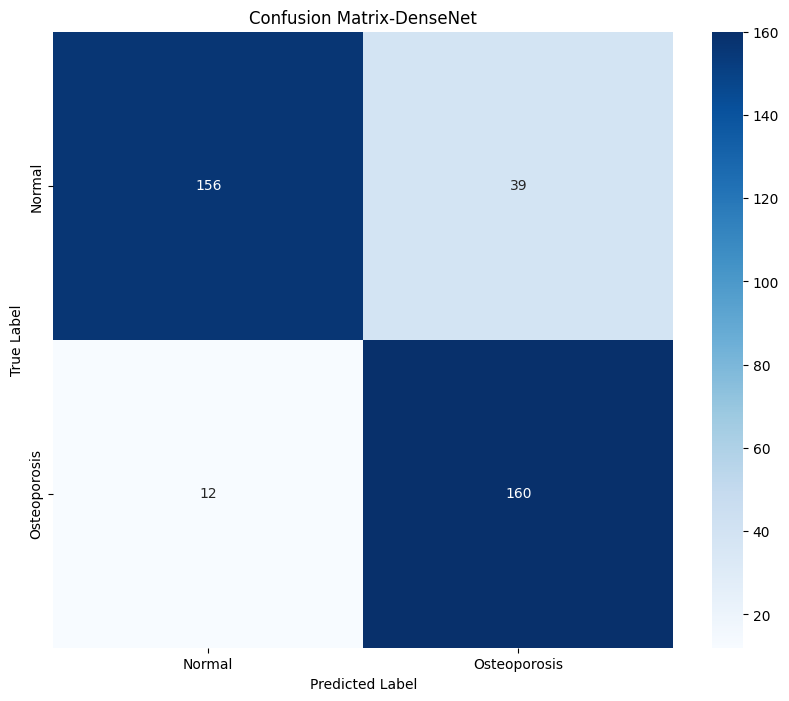

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_v = confusion_matrix(y_true, y_pred_classes_v)
sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix-DenseNet')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_v, target_names=class_names))


Classification Report-VGG19:
              precision    recall  f1-score   support

      Normal       0.97      0.86      0.91       195
Osteoporosis       0.86      0.97      0.91       172

    accuracy                           0.91       367
   macro avg       0.91      0.91      0.91       367
weighted avg       0.92      0.91      0.91       367



In [ ]:
history1 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8083 - loss: 8.2528 - val_accuracy: 0.8245 - val_loss: 8.0879
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8351 - loss: 7.9245 - val_accuracy: 0.7918 - val_loss: 7.9943
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.7956 - loss: 7.6943 - val_accuracy: 0.8327 - val_loss: 7.5159
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8183 - loss: 7.3852 - val_accuracy: 0.8653 - val_loss: 7.1170
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8327 - loss: 7.1418 - val_accuracy: 0.8490 - val_loss: 6.8819
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8420 - loss: 6.7601 - val_accuracy: 0.8367 - val_loss: 6.6451
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8557 - loss: 6.4836 - val_accuracy: 0.8286 - val_loss: 6.3134
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8332 - loss: 6.2199 - 

In [ ]:
model.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8872 - loss: 5.4573


[5.470343112945557, 0.888283371925354]

In [ ]:
history2 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8751 - loss: 5.4304 - val_accuracy: 0.8816 - val_loss: 5.2184
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8885 - loss: 5.1255 - val_accuracy: 0.8694 - val_loss: 4.9697
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8701 - loss: 4.8866 - val_accuracy: 0.8735 - val_loss: 4.7084
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8493 - loss: 4.6659 - val_accuracy: 0.8694 - val_loss: 4.5162
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8564 - loss: 4.4166 - val_accuracy: 0.8653 - val_loss: 4.2688
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9168 - loss: 4.1225 - val_accuracy: 0.8694 - val_loss: 4.0559
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8614 - loss: 3.9631 - val_accuracy: 0.8163 - val_loss: 3.9365
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9112 - loss: 3.7069 - 

In [ ]:
model.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8540 - loss: 3.2270


[3.223909616470337, 0.8692098259925842]

In [ ]:
model.save("osteoporosisdense1.keras")

In [ ]:
history3 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8864 - loss: 3.1359 - val_accuracy: 0.8245 - val_loss: 3.1827
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8940 - loss: 2.9366 - val_accuracy: 0.8490 - val_loss: 2.8979
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9015 - loss: 2.7578 - val_accuracy: 0.8694 - val_loss: 2.6906
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8769 - loss: 2.6432 - val_accuracy: 0.8898 - val_loss: 2.5284
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9057 - loss: 2.4416 - val_accuracy: 0.8531 - val_loss: 2.4234
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8953 - loss: 2.2828 - val_accuracy: 0.8653 - val_loss: 2.2504
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9141 - loss: 2.1360 - val_accuracy: 0.8612 - val_loss: 2.1562
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8944 - loss: 2.0141 - 

In [ ]:
model.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.8821 - loss: 1.7487


[1.7107900381088257, 0.9100817441940308]

In [ ]:
history4 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9356 - loss: 1.6341 - val_accuracy: 0.8449 - val_loss: 1.6865
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9109 - loss: 1.5478 - val_accuracy: 0.8531 - val_loss: 1.5670
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9157 - loss: 1.4497 - val_accuracy: 0.8694 - val_loss: 1.4918
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9545 - loss: 1.3112 - val_accuracy: 0.8653 - val_loss: 1.4115
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9182 - loss: 1.2851 - val_accuracy: 0.8653 - val_loss: 1.2848
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9252 - loss: 1.1796 - val_accuracy: 0.8735 - val_loss: 1.2503
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9299 - loss: 1.1148 - val_accuracy: 0.8490 - val_loss: 1.1784
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9219 - loss: 1.0638 - 

In [ ]:
model.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.8817 - loss: 0.9532


[0.9356802701950073, 0.888283371925354]

In [ ]:
history5 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9500 - loss: 0.5249 - val_accuracy: 0.8735 - val_loss: 0.6249
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9392 - loss: 0.5181 - val_accuracy: 0.8735 - val_loss: 0.6187
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9163 - loss: 0.5161 - val_accuracy: 0.8939 - val_loss: 0.5886
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9374 - loss: 0.4975 - val_accuracy: 0.8531 - val_loss: 0.5759
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9356 - loss: 0.4762 - val_accuracy: 0.8898 - val_loss: 0.5764
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9451 - loss: 0.4555 - val_accuracy: 0.8816 - val_loss: 0.5351
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9252 - loss: 0.4607 - val_accuracy: 0.8653 - val_loss: 0.5837
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9515 - loss: 0.4310 - 

In [ ]:
model.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9256 - loss: 0.4703


[0.45839613676071167, 0.9264305233955383]

In [ ]:
model.save("osteoporosisdensebest.keras")

In [ ]:
y_pred_v = model.predict(test)
y_pred_classes_v = np.argmax(y_pred_v, axis=1)
y_true = test.classes

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step


Text(95.72222222222221, 0.5, 'True Label')

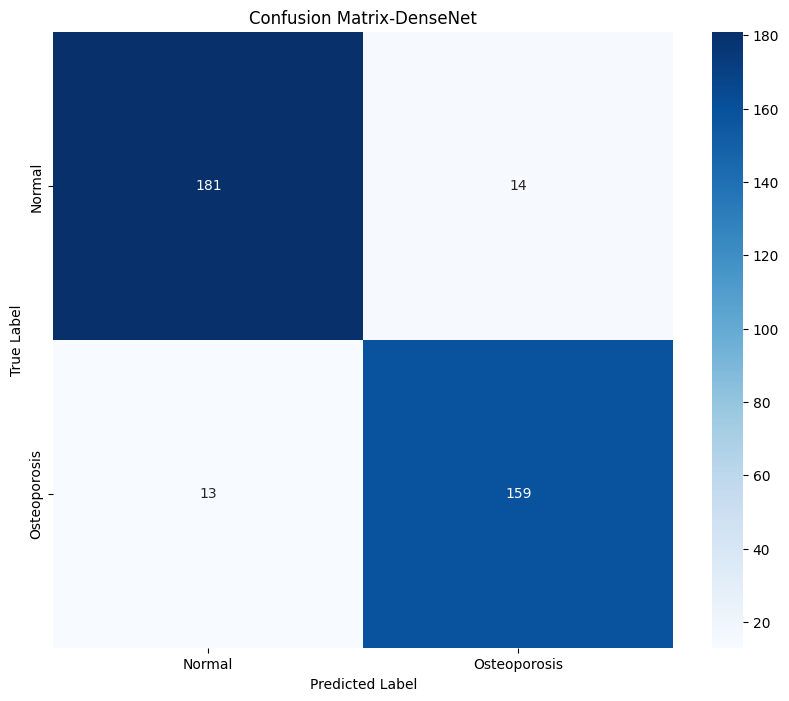

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_v = confusion_matrix(y_true, y_pred_classes_v)
sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix-DenseNet')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_v, target_names=class_names))


Classification Report-VGG19:
              precision    recall  f1-score   support

      Normal       0.93      0.93      0.93       195
Osteoporosis       0.92      0.92      0.92       172

    accuracy                           0.93       367
   macro avg       0.93      0.93      0.93       367
weighted avg       0.93      0.93      0.93       367



In [ ]:
y_true = test.classes

In [ ]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
f1= f1_score(y_true, y_pred_classes_v)
acc= accuracy_score(y_true, y_pred_classes_v)
precision= precision_score(y_true, y_pred_classes_v)
recall= recall_score(y_true, y_pred_classes_v)

In [ ]:
print("F1 Score: ", f1)
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)

F1 Score:  0.9217391304347826
Accuracy:  0.9264305177111717
Precision:  0.9190751445086706
Recall:  0.9244186046511628


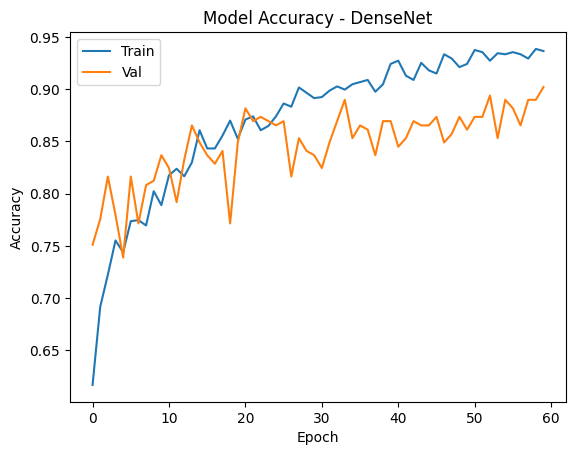

In [ ]:
plt.plot(history.history["accuracy"]+
history1.history["accuracy"] +
history2.history["accuracy"] +
history3.history["accuracy"] +
history4.history["accuracy"] +
history5.history["accuracy"])
plt.plot(history.history["val_accuracy"] +
history1.history["val_accuracy"] +
history2.history["val_accuracy"] +
history3.history["val_accuracy"] +
history4.history["val_accuracy"] +
history5.history["val_accuracy"])
plt.title('Model Accuracy - DenseNet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

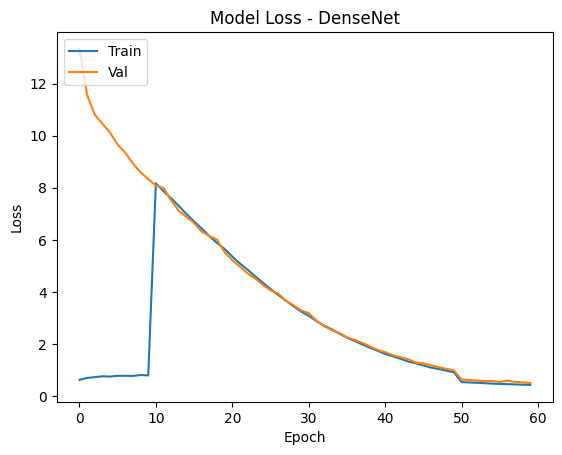

In [ ]:
plt.plot(history.history["accuracy"]+
history1.history["loss"] +
history2.history["loss"] +
history3.history["loss"] +
history4.history["loss"] +
history5.history["loss"])
plt.plot(history.history["val_loss"] +
history1.history["val_loss"] +
history2.history["val_loss"] +
history3.history["val_loss"] +
history4.history["val_loss"] +
history5.history["val_loss"])
plt.title('Model Loss - DenseNet')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 47.9 MB/s eta 0:00:00


In [ ]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model, legend=True)

-----------------------------------------------------------------

In [ ]:
history6 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.9316 - loss: 0.5016 - val_accuracy: 0.8857 - val_loss: 0.5704
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9281 - loss: 0.4945 - val_accuracy: 0.8776 - val_loss: 0.6364
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9532 - loss: 0.4585 - val_accuracy: 0.8857 - val_loss: 0.5479
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9256 - loss: 0.4596 - val_accuracy: 0.8816 - val_loss: 0.5247
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9483 - loss: 0.4328 - val_accuracy: 0.8694 - val_loss: 0.5933
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9462 - loss: 0.4335 - val_accuracy: 0.8735 - val_loss: 0.5610
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9452 - loss: 0.4134 - val_accuracy: 0.8735 - val_loss: 0.5282
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9394 - loss: 0.4238 - 

In [ ]:
model.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9043 - loss: 0.4638


[0.4392717182636261, 0.9291552901268005]

In [ ]:
history7 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9359 - loss: 0.3944 - val_accuracy: 0.8980 - val_loss: 0.4846
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9430 - loss: 0.3851 - val_accuracy: 0.8816 - val_loss: 0.5053
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9289 - loss: 0.3955 - val_accuracy: 0.8857 - val_loss: 0.5117
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9260 - loss: 0.3972 - val_accuracy: 0.8980 - val_loss: 0.4844
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9358 - loss: 0.3813 - val_accuracy: 0.8857 - val_loss: 0.4679
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9341 - loss: 0.3863 - val_accuracy: 0.8939 - val_loss: 0.4543
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9426 - loss: 0.3814 - val_accuracy: 0.8612 - val_loss: 0.4984
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9330 - loss: 0.3935 - 

In [ ]:
model.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9302 - loss: 0.4242


[0.4267416298389435, 0.9155313372612]

In [ ]:
history8 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9225 - loss: 0.3812 - val_accuracy: 0.8898 - val_loss: 0.4411
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9485 - loss: 0.3530 - val_accuracy: 0.8694 - val_loss: 0.4623
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9432 - loss: 0.3684 - val_accuracy: 0.8694 - val_loss: 0.4874
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9308 - loss: 0.3665 - val_accuracy: 0.8816 - val_loss: 0.4705
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9481 - loss: 0.3483 - val_accuracy: 0.8898 - val_loss: 0.4462
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9314 - loss: 0.3648 - val_accuracy: 0.8735 - val_loss: 0.4949
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9308 - loss: 0.3648 - val_accuracy: 0.8939 - val_loss: 0.4707
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9168 - loss: 0.3761 - 

In [ ]:
model.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9058 - loss: 0.4369


[0.42818328738212585, 0.8964577913284302]

In [ ]:
history9 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9499 - loss: 0.3603 - val_accuracy: 0.8694 - val_loss: 0.5083
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9041 - loss: 0.3980 - val_accuracy: 0.9020 - val_loss: 0.4145
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9392 - loss: 0.3535 - val_accuracy: 0.8776 - val_loss: 0.4773
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9344 - loss: 0.3601 - val_accuracy: 0.8980 - val_loss: 0.4551
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9526 - loss: 0.3503 - val_accuracy: 0.8939 - val_loss: 0.4900
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9336 - loss: 0.3537 - val_accuracy: 0.8939 - val_loss: 0.4466
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9288 - loss: 0.3640 - val_accuracy: 0.9020 - val_loss: 0.4353
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9307 - loss: 0.3552 - 

In [ ]:
model.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9191 - loss: 0.4101


[0.4033275544643402, 0.9182561039924622]

In [ ]:
plt.plot(history.history["accuracy"]+
history1.history["accuracy"] +
history2.history["accuracy"] +
history3.history["accuracy"] +
history4.history["accuracy"] +
history5.history["accuracy"]+
history6.history["accuracy"]+
history7.history["accuracy"]+
history8.history["accuracy"]+
history9.history["accuracy"])
plt.plot(history.history["val_accuracy"] +
history1.history["val_accuracy"] +
history2.history["val_accuracy"] +
history3.history["val_accuracy"] +
history4.history["val_accuracy"] +
history5.history["val_accuracy"])
plt.title('Model Accuracy - DenseNet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
history10 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9504 - loss: 0.3452 - val_accuracy: 0.8857 - val_loss: 0.4512
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9505 - loss: 0.3478 - val_accuracy: 0.8816 - val_loss: 0.4421
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9266 - loss: 0.3724 - val_accuracy: 0.8735 - val_loss: 0.4691
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9213 - loss: 0.3642 - val_accuracy: 0.8898 - val_loss: 0.4596
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9413 - loss: 0.3487 - val_accuracy: 0.9020 - val_loss: 0.4749
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9092 - loss: 0.3732 - val_accuracy: 0.9102 - val_loss: 0.4361
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9448 - loss: 0.3366 - val_accuracy: 0.8776 - val_loss: 0.5413
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.9448 - loss: 0.3431 - 

In [ ]:
model.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9082 - loss: 0.4140


[0.41008102893829346, 0.9100817441940308]

In [ ]:
y_pred_v = model.predict(test_generator)
y_pred_classes_v = np.argmax(y_pred_v, axis=1)
y_true = test_generator.classes

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step


In [ ]:
y_true = test_generator.classes

Text(95.72222222222221, 0.5, 'True Label')

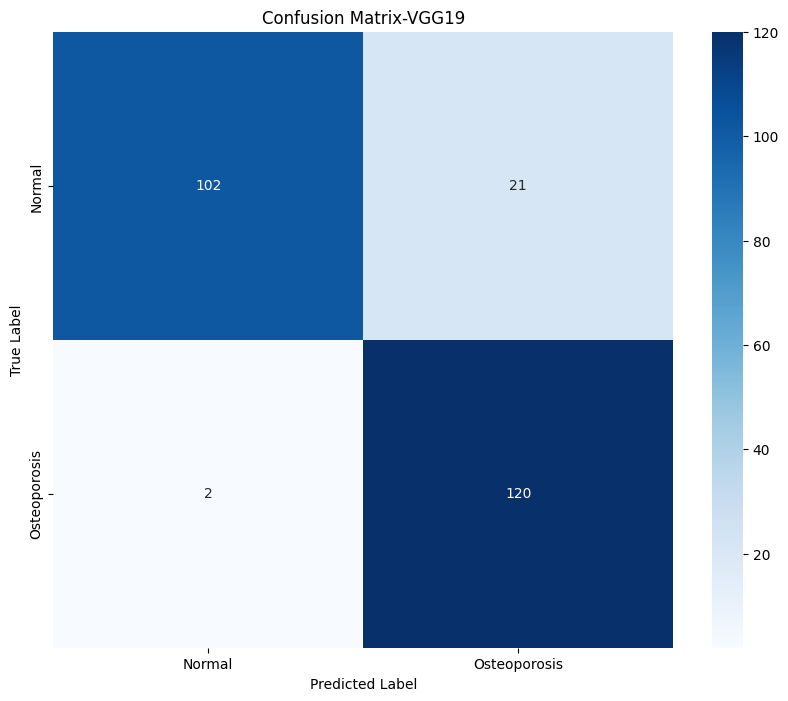

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_v = confusion_matrix(y_true, y_pred_classes_v)
sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix-VGG19')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_v, target_names=class_names))


Classification Report-VGG19:
              precision    recall  f1-score   support

      Normal       0.98      0.83      0.90       123
Osteoporosis       0.85      0.98      0.91       122

    accuracy                           0.91       245
   macro avg       0.92      0.91      0.91       245
weighted avg       0.92      0.91      0.91       245



In [ ]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
f1= f1_score(y_true, y_pred_classes_v)
acc= accuracy_score(y_true, y_pred_classes_v)
precision= precision_score(y_true, y_pred_classes_v)
recall= recall_score(y_true, y_pred_classes_v)

ValueError: Found input variables with inconsistent numbers of samples: [367, 245]

---------------------------------------------------------------------------------------------

In [ ]:
history11 = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 384ms/step - accuracy: 0.4765 - loss: 5.3005 - val_accuracy: 0.5574 - val_loss: 5.1363
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 349ms/step - accuracy: 0.5013 - loss: 5.2688 - val_accuracy: 0.5123 - val_loss: 5.0961
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 393ms/step - accuracy: 0.5001 - loss: 5.1997 - val_accuracy: 0.4590 - val_loss: 5.0597
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 365ms/step - accuracy: 0.4849 - loss: 5.1774 - val_accuracy: 0.4795 - val_loss: 4.9977
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 374ms/step - accuracy: 0.4866 - loss: 5.0754 - val_accuracy: 0.4180 - val_loss: 4.9595


In [ ]:
model.evaluate(test_generator, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step - accuracy: 0.4972 - loss: 4.9537


[4.948517322540283, 0.4734693765640259]

In [ ]:
history12 = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 446ms/step - accuracy: 0.5673 - loss: 4.9738 - val_accuracy: 0.4590 - val_loss: 4.8932
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - accuracy: 0.5044 - loss: 4.9646 - val_accuracy: 0.4795 - val_loss: 4.8289
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 367ms/step - accuracy: 0.5122 - loss: 4.8787 - val_accuracy: 0.5861 - val_loss: 4.7418
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - accuracy: 0.5457 - loss: 4.8205 - val_accuracy: 0.5615 - val_loss: 4.6900
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 325ms/step - accuracy: 0.4827 - loss: 4.8014 - val_accuracy: 0.6230 - val_loss: 4.6279


In [ ]:
model.evaluate(test_generator, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 421ms/step - accuracy: 0.6493 - loss: 4.6197


[4.620971202850342, 0.6040816307067871]

In [ ]:
history13 = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 438ms/step - accuracy: 0.5630 - loss: 4.6848 - val_accuracy: 0.5984 - val_loss: 4.5721
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 327ms/step - accuracy: 0.5199 - loss: 4.6387 - val_accuracy: 0.5410 - val_loss: 4.5477
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.4875 - loss: 4.6569 - val_accuracy: 0.5451 - val_loss: 4.4836
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 363ms/step - accuracy: 0.5324 - loss: 4.5626 - val_accuracy: 0.4180 - val_loss: 4.4697
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.4713 - loss: 4.5324 - val_accuracy: 0.5902 - val_loss: 4.3720


In [ ]:
model.evaluate(test_generator, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - accuracy: 0.6114 - loss: 4.3824


[4.366033554077148, 0.6122449040412903]

In [ ]:
y_pred_v = model.predict(test_generator)
y_pred_classes_v = np.argmax(y_pred_v, axis=1)
y_true = test_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step


Text(95.72222222222221, 0.5, 'True Label')

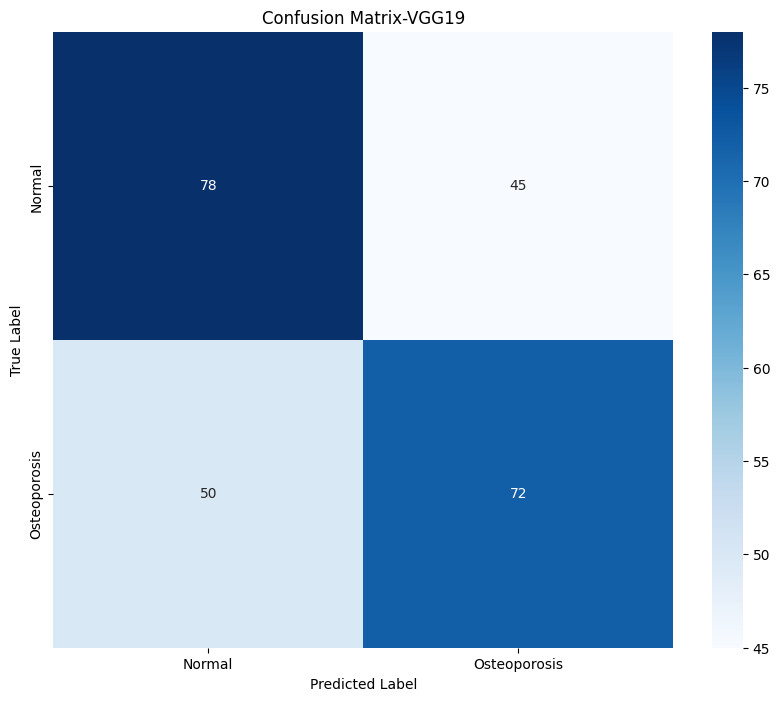

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_v = confusion_matrix(y_true, y_pred_classes_v)
sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix-VGG19')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
history14 = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 442ms/step - accuracy: 0.5035 - loss: 4.4422 - val_accuracy: 0.6680 - val_loss: 4.3027
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 384ms/step - accuracy: 0.4892 - loss: 4.4124 - val_accuracy: 0.5287 - val_loss: 4.2887
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 379ms/step - accuracy: 0.5502 - loss: 4.3225 - val_accuracy: 0.5574 - val_loss: 4.2289
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.5030 - loss: 4.3068 - val_accuracy: 0.6066 - val_loss: 4.1730
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 376ms/step - accuracy: 0.4910 - loss: 4.2415 - val_accuracy: 0.5656 - val_loss: 4.1327


In [ ]:
model.evaluate(test_generator, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.5460 - loss: 4.1478


[4.142253875732422, 0.518367350101471]

In [ ]:
history15 = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 377ms/step - accuracy: 0.5437 - loss: 4.1621 - val_accuracy: 0.5492 - val_loss: 4.0937
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 402ms/step - accuracy: 0.5474 - loss: 4.1081 - val_accuracy: 0.5410 - val_loss: 4.0497
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.5087 - loss: 4.1295 - val_accuracy: 0.5943 - val_loss: 3.9898
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 366ms/step - accuracy: 0.5321 - loss: 4.0535 - val_accuracy: 0.6434 - val_loss: 3.9193
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 340ms/step - accuracy: 0.5180 - loss: 3.9952 - val_accuracy: 0.5451 - val_loss: 3.9039


In [ ]:
model.evaluate(test_generator, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - accuracy: 0.6373 - loss: 3.8774


[3.893894910812378, 0.5469387769699097]

In [ ]:
history16 = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.5157 - loss: 3.9352 - val_accuracy: 0.5820 - val_loss: 3.8358
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 364ms/step - accuracy: 0.5056 - loss: 3.8891 - val_accuracy: 0.5902 - val_loss: 3.7837
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - accuracy: 0.5108 - loss: 3.8700 - val_accuracy: 0.5984 - val_loss: 3.7460
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 397ms/step - accuracy: 0.5012 - loss: 3.8388 - val_accuracy: 0.5861 - val_loss: 3.7007
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 370ms/step - accuracy: 0.5107 - loss: 3.7573 - val_accuracy: 0.6025 - val_loss: 3.6441


In [ ]:
model.evaluate(test_generator, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.6535 - loss: 3.6426


[3.6370716094970703, 0.6489796042442322]

In [ ]:
history17 = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 436ms/step - accuracy: 0.5413 - loss: 3.7380 - val_accuracy: 0.5492 - val_loss: 3.6245
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 377ms/step - accuracy: 0.4965 - loss: 3.6884 - val_accuracy: 0.4959 - val_loss: 3.5900
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 373ms/step - accuracy: 0.4765 - loss: 3.6578 - val_accuracy: 0.6148 - val_loss: 3.5143
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.5627 - loss: 3.5526 - val_accuracy: 0.5984 - val_loss: 3.4882
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 407ms/step - accuracy: 0.5257 - loss: 3.5209 - val_accuracy: 0.6352 - val_loss: 3.4371


In [ ]:
model.evaluate(test_generator, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.6587 - loss: 3.4343


[3.439840793609619, 0.6122449040412903]

In [ ]:
history18 = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.5203 - loss: 3.4976 - val_accuracy: 0.5656 - val_loss: 3.4013
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 388ms/step - accuracy: 0.5053 - loss: 3.4420 - val_accuracy: 0.4713 - val_loss: 3.3850
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.5101 - loss: 3.4225 - val_accuracy: 0.5287 - val_loss: 3.3264
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 398ms/step - accuracy: 0.5511 - loss: 3.3420 - val_accuracy: 0.5205 - val_loss: 3.2977
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 394ms/step - accuracy: 0.5121 - loss: 3.3214 - val_accuracy: 0.5164 - val_loss: 3.2687


In [ ]:
model.evaluate(test_generator, verbose=1)

In [ ]:
history19 = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 444ms/step - accuracy: 0.5558 - loss: 3.2843 - val_accuracy: 0.6025 - val_loss: 3.1921
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 379ms/step - accuracy: 0.4982 - loss: 3.2614 - val_accuracy: 0.4631 - val_loss: 3.1948
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 385ms/step - accuracy: 0.5120 - loss: 3.1954 - val_accuracy: 0.6025 - val_loss: 3.1114
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 341ms/step - accuracy: 0.5571 - loss: 3.1430 - val_accuracy: 0.3975 - val_loss: 3.1432
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 411ms/step - accuracy: 0.5032 - loss: 3.1489 - val_accuracy: 0.6434 - val_loss: 3.0272


In [ ]:
model.evaluate(test_generator, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - accuracy: 0.6675 - loss: 3.0200


[3.0183756351470947, 0.6448979377746582]

In [ ]:
history20 = model.fit(train_generator, epochs=5, validation_data=validation_generator, verbose=1)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 432ms/step - accuracy: 0.5611 - loss: 3.0553 - val_accuracy: 0.5000 - val_loss: 3.0288
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - accuracy: 0.5186 - loss: 3.0435 - val_accuracy: 0.5000 - val_loss: 2.9920
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 364ms/step - accuracy: 0.4903 - loss: 3.0161 - val_accuracy: 0.5984 - val_loss: 2.9261
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.5027 - loss: 2.9925 - val_accuracy: 0.6107 - val_loss: 2.8760
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 403ms/step - accuracy: 0.5185 - loss: 2.9586 - val_accuracy: 0.5943 - val_loss: 2.8466


In [ ]:
model.evaluate(test_generator, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.6544 - loss: 2.8496


[2.855539560317993, 0.5755102038383484]

In [ ]:
# Store class names
class_names = list(train_generator.class_indices.keys())
print("Classes:", class_names)
NUM_CLASSES = len(class_names)

Classes: ['Normal', 'Osteoporosis']


In [ ]:
# Callbacks
# Create output directory
OUTPUT_DIR = '/content/drive/MyDrive/osteoporosis_model'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Model checkpoint
checkpoint = ModelCheckpoint(
    os.path.join(OUTPUT_DIR, 'best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True
)

In [ ]:
# Reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

Models:

1.VGG19

2.ResNet

3.DenseNet


##VGG19

In [ ]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Load DenseNet201 as the backbone
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Freeze the initial layers
for layer in vgg_model.layers:
    layer.trainable = False

# Add custom layers
x = vgg_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model2 = Model(inputs=vgg_model.input, outputs=output)

# Unfreeze the last 50 layers for fine-tuning
for layer in densenet_model.layers[-50:]:
    layer.trainable = True

# Compile the model
model2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Add label smoothing
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model2.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 244, 244, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 244, 244, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 122, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 122, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 61, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,081,666 (80.42 MB)

 Trainable params: 1,054,210 (4.02 MB)

 Non-trainable params: 20,027,456 (76.40 MB)

In [ ]:
historyv = model2.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.5659 - loss: 13.2067 - val_accuracy: 0.7061 - val_loss: 9.5488
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.6687 - loss: 9.2863 - val_accuracy: 0.7510 - val_loss: 7.8989
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6886 - loss: 7.9163 - val_accuracy: 0.7510 - val_loss: 7.3117
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6717 - loss: 7.3661 - val_accuracy: 0.8041 - val_loss: 6.8167
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.6934 - loss: 6.9346 - val_accuracy: 0.7959 - val_loss: 6.5435
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.7298 - loss: 6.6627 - val_accuracy: 0.8204 - val_loss: 6.4275
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6963 - loss: 6.4274 - val_accuracy: 0.8041 - val_loss: 6.0927
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7077 - loss: 6.2455 -

In [ ]:
model2.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8246 - loss: 5.4077


[5.434895038604736, 0.8256130814552307]

In [ ]:
historyv1 = model2.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7073 - loss: 5.5535 - val_accuracy: 0.8082 - val_loss: 5.2541
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7569 - loss: 5.2886 - val_accuracy: 0.8327 - val_loss: 5.0365
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.7258 - loss: 5.1477 - val_accuracy: 0.8122 - val_loss: 4.9015
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7584 - loss: 4.9530 - val_accuracy: 0.8204 - val_loss: 4.6681
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.7514 - loss: 4.8444 - val_accuracy: 0.8286 - val_loss: 4.5210
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.7558 - loss: 4.6172 - val_accuracy: 0.7959 - val_loss: 4.5178
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.7470 - loss: 4.4690 - val_accuracy: 0.8204 - val_loss: 4.2263
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.7753 - loss: 4.2924 - 

In [ ]:
model2.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8110 - loss: 3.9290


[3.9435951709747314, 0.8092643022537231]

In [ ]:
historyv2 = model2.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.7780 - loss: 3.8178 - val_accuracy: 0.8490 - val_loss: 3.6357
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7843 - loss: 3.6777 - val_accuracy: 0.8286 - val_loss: 3.4798
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8086 - loss: 3.5165 - val_accuracy: 0.8163 - val_loss: 3.3843
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7715 - loss: 3.4544 - val_accuracy: 0.7796 - val_loss: 3.4845
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8051 - loss: 3.3046 - val_accuracy: 0.8327 - val_loss: 3.1738
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7961 - loss: 3.1670 - val_accuracy: 0.8000 - val_loss: 3.0859
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.7774 - loss: 3.0648 - val_accuracy: 0.7714 - val_loss: 2.9873
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7982 - loss: 2.9372 - 

In [ ]:
model2.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8053 - loss: 2.6902


[2.6783478260040283, 0.8337874412536621]

In [ ]:
historyv3 = model2.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.7488 - loss: 2.6901 - val_accuracy: 0.8041 - val_loss: 2.5532
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7819 - loss: 2.5606 - val_accuracy: 0.6531 - val_loss: 2.8124
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8351 - loss: 2.4496 - val_accuracy: 0.8286 - val_loss: 2.3803
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8181 - loss: 2.3611 - val_accuracy: 0.8041 - val_loss: 2.3421
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8095 - loss: 2.2525 - val_accuracy: 0.7837 - val_loss: 2.3656
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8180 - loss: 2.1936 - val_accuracy: 0.8327 - val_loss: 2.0633
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8423 - loss: 2.0751 - val_accuracy: 0.8122 - val_loss: 2.1702
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8582 - loss: 1.9651 - 

In [ ]:
model2.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8275 - loss: 1.9368


[1.9645392894744873, 0.8201634883880615]

In [ ]:
historyv4 = model2.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7720 - loss: 1.8880 - val_accuracy: 0.8327 - val_loss: 1.7503
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8131 - loss: 1.7518 - val_accuracy: 0.8163 - val_loss: 1.7091
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8163 - loss: 1.6825 - val_accuracy: 0.8286 - val_loss: 1.6092
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8415 - loss: 1.6139 - val_accuracy: 0.8041 - val_loss: 1.6409
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8303 - loss: 1.5672 - val_accuracy: 0.8163 - val_loss: 1.5949
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8425 - loss: 1.4875 - val_accuracy: 0.7673 - val_loss: 1.8537
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8452 - loss: 1.4537 - val_accuracy: 0.8041 - val_loss: 1.5577
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8359 - loss: 1.4166 - 

In [ ]:
model2.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.7666 - loss: 1.4035


[1.409784197807312, 0.7847411632537842]

In [ ]:
historyv5 = model2.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8207 - loss: 1.2864 - val_accuracy: 0.8163 - val_loss: 1.2893
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8272 - loss: 1.2674 - val_accuracy: 0.6082 - val_loss: 1.8053
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8362 - loss: 1.1967 - val_accuracy: 0.8204 - val_loss: 1.2012
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8361 - loss: 1.1559 - val_accuracy: 0.7143 - val_loss: 1.3567
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8489 - loss: 1.1372 - val_accuracy: 0.8163 - val_loss: 1.1980
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.8602 - loss: 1.0829 - val_accuracy: 0.8245 - val_loss: 1.1023
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8335 - loss: 1.0791 - val_accuracy: 0.6204 - val_loss: 1.5439
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.8466 - loss: 1.0494 - 

In [ ]:
model2.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9053 - loss: 0.9391


[0.9404612183570862, 0.8828337788581848]

In [ ]:
y_pred_vg = model2.predict(test)
y_pred_classes_vg = np.argmax(y_pred_vg, axis=1)
y_true = test.classes

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


Text(95.72222222222221, 0.5, 'True Label')

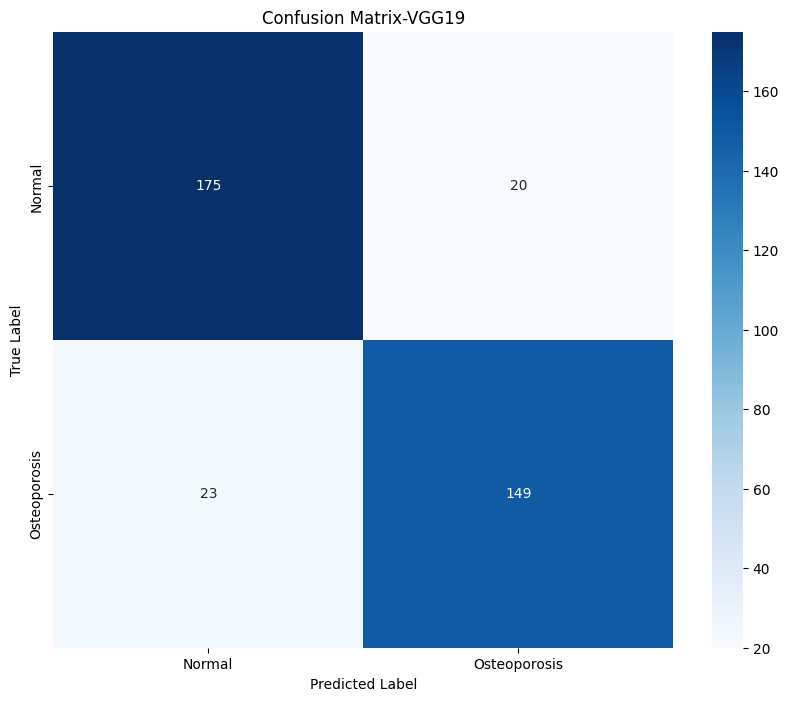

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_vg = confusion_matrix(y_true, y_pred_classes_vg)
sns.heatmap(cm_vg, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix-VGG19')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

Text(0.5, 1.0, 'Confusion Matrix-DenseNet')

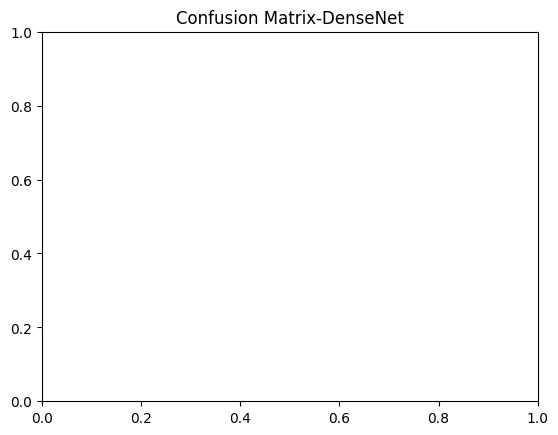

In [ ]:
plt.title('Confusion Matrix-DenseNet')

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_vg, target_names=class_names))


Classification Report-VGG19:
              precision    recall  f1-score   support

      Normal       0.88      0.90      0.89       195
Osteoporosis       0.88      0.87      0.87       172

    accuracy                           0.88       367
   macro avg       0.88      0.88      0.88       367
weighted avg       0.88      0.88      0.88       367



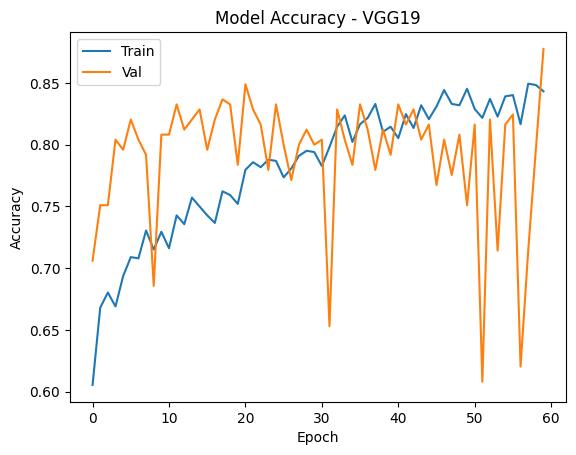

In [ ]:
plt.plot(historyv.history["accuracy"]+
historyv1.history["accuracy"] +
historyv2.history["accuracy"] +
historyv3.history["accuracy"] +
historyv4.history["accuracy"] +
historyv5.history["accuracy"])
plt.plot(historyv.history["val_accuracy"] +
historyv1.history["val_accuracy"] +
historyv2.history["val_accuracy"] +
historyv3.history["val_accuracy"] +
historyv4.history["val_accuracy"] +
historyv5.history["val_accuracy"])
plt.title('Model Accuracy - VGG19')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
f1= f1_score(y_true, y_pred_classes_vg)
acc= accuracy_score(y_true, y_pred_classes_vg)
precision= precision_score(y_true, y_pred_classes_vg)
recall= recall_score(y_true, y_pred_classes_vg)

In [ ]:
print("F1 Score: ", f1)
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)

F1 Score:  0.873900293255132
Accuracy:  0.8828337874659401
Precision:  0.8816568047337278
Recall:  0.8662790697674418


--------------------------------------------------------------------------------

In [ ]:
basemodel3= VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Freeze base model layers
basemodel3.trainable = False

In [ ]:
#customize or finetune the VGG19 model
x = basemodel3.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=basemodel3.input, outputs=output)

In [ ]:
# Unfreeze the last 50 layers for fine-tuning
for layer in basemodel3.layers[-50:]:
    layer.trainable = True

In [ ]:
# Compile model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,081,153 (80.42 MB)

 Trainable params: 21,078,081 (80.41 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [ ]:
# Train the model
historybv1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.5598 - loss: 14.4106 - val_accuracy: 0.5041 - val_loss: 18.3746 - learning_rate: 1.0000e-04
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 621ms/step - accuracy: 0.5926 - loss: 13.7271 - val_accuracy: 0.5041 - val_loss: 19.5126 - learning_rate: 1.0000e-04
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 585ms/step - accuracy: 0.6361 - loss: 13.1549 - val_accuracy: 0.5041 - val_loss: 15.8405 - learning_rate: 1.0000e-04
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 625ms/step - accuracy: 0.6758 - loss: 12.6431 - val_accuracy: 0.5041 - val_loss: 15.9872 - learning_rate: 1.0000e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 595ms/step - accuracy: 0.6396 - loss: 12.2131 - val_accuracy: 0.5041 - val_loss: 31.1965 - learning_rate: 1.0000e-04
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 634ms/step - accuracy: 0.6671 - loss: 11.8022 - val_accuracy: 0.5041 - val_loss: 15.7552 - learning_rate: 1.0000e-04
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 616ms/step - accu

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.7331 - loss: 5.8004
Validation Accuracy: 0.76


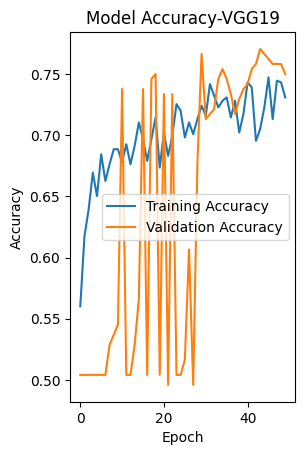

In [ ]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(historybv1.history['accuracy'], label='Training Accuracy')
plt.plot(historybv1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy-VGG19')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

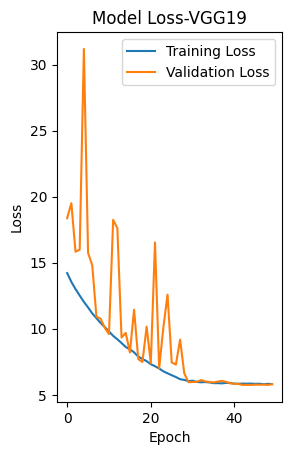

In [ ]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(historybv1.history['loss'], label='Training Loss')
plt.plot(historybv1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss-VGG19')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Evaluation on Validation Data
# Predict on validation data
y_pred_v = model.predict(test_generator)
y_pred_classes_v = np.argmax(y_pred_v, axis=1)
y_true = test_generator.classes

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 883ms/step


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 525ms/step - accuracy: 0.7372 - loss: 5.8101
Test Accuracy: 0.80


Text(95.72222222222221, 0.5, 'True Label')

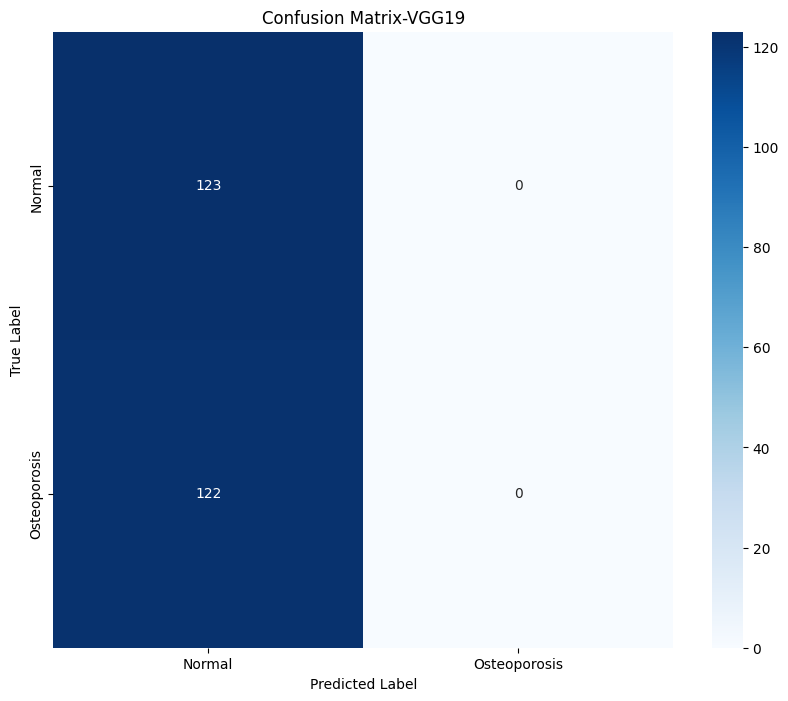

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_v = confusion_matrix(y_true, y_pred_classes_v)
sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix-VGG19')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_v, target_names=class_names))


Classification Report-VGG19:
              precision    recall  f1-score   support

      Normal       0.50      1.00      0.67       123
Osteoporosis       0.00      0.00      0.00       122

    accuracy                           0.50       245
   macro avg       0.25      0.50      0.33       245
weighted avg       0.25      0.50      0.34       245



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Train the model
historybv2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 643ms/step - accuracy: 0.7401 - loss: 5.8169 - val_accuracy: 0.7377 - val_loss: 5.8151 - learning_rate: 4.0000e-06
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 624ms/step - accuracy: 0.7447 - loss: 5.7701 - val_accuracy: 0.7418 - val_loss: 5.8007 - learning_rate: 4.0000e-06
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 603ms/step - accuracy: 0.7450 - loss: 5.7680 - val_accuracy: 0.7459 - val_loss: 5.7672 - learning_rate: 4.0000e-06
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 604ms/step - accuracy: 0.7084 - loss: 5.8822 - val_accuracy: 0.7500 - val_loss: 5.7372 - learning_rate: 4.0000e-06
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 604ms/step - accuracy: 0.7311 - loss: 5.8230 - val_accuracy: 0.7623 - val_loss: 5.7092 - learning_rate: 4.0000e-06
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 572ms/step - accuracy: 0.7186 - loss: 5.7559 - val_accuracy: 0.7623 - val_loss: 5.6995 - learning_rate: 4.0000e-06
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 619ms/step - acc

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 0.7123 - loss: 5.9288
Test Accuracy: 0.80


In [ ]:
# Train the model
historybv3 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 641ms/step - accuracy: 0.6987 - loss: 5.8519 - val_accuracy: 0.7213 - val_loss: 5.8798 - learning_rate: 4.0000e-06
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 608ms/step - accuracy: 0.7685 - loss: 5.7355 - val_accuracy: 0.7459 - val_loss: 5.7956 - learning_rate: 4.0000e-06
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 601ms/step - accuracy: 0.7218 - loss: 5.7628 - val_accuracy: 0.7623 - val_loss: 5.7005 - learning_rate: 4.0000e-06
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 618ms/step - accuracy: 0.7000 - loss: 5.7794 - val_accuracy: 0.7500 - val_loss: 5.7663 - learning_rate: 4.0000e-06
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 592ms/step - accuracy: 0.7350 - loss: 5.7896 - val_accuracy: 0.7459 - val_loss: 5.7617 - learning_rate: 4.0000e-06
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 617ms/step - accuracy: 0.7559 - loss: 5.7965 - val_accuracy: 0.7418 - val_loss: 5.7402 - learning_rate: 4.0000e-06
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 611ms/step - acc

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step - accuracy: 0.6822 - loss: 6.0323
Test Accuracy: 0.79


In [ ]:
# Train the model
historybv4 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 645ms/step - accuracy: 0.7332 - loss: 5.7589 - val_accuracy: 0.7418 - val_loss: 5.8150
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 608ms/step - accuracy: 0.7438 - loss: 5.7555 - val_accuracy: 0.7459 - val_loss: 5.7648
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 613ms/step - accuracy: 0.7715 - loss: 5.7161 - val_accuracy: 0.7582 - val_loss: 5.7389
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 598ms/step - accuracy: 0.7331 - loss: 5.7971 - val_accuracy: 0.7705 - val_loss: 5.7239
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 608ms/step - accuracy: 0.7103 - loss: 5.7438 - val_accuracy: 0.7582 - val_loss: 5.7396


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step - accuracy: 0.7209 - loss: 5.8028
Test Accuracy: 0.79


In [ ]:
# Train the model
historybv5 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - accuracy: 0.7438 - loss: 5.7692 - val_accuracy: 0.7541 - val_loss: 5.7438
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 619ms/step - accuracy: 0.7634 - loss: 5.7613 - val_accuracy: 0.7582 - val_loss: 5.7325
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 613ms/step - accuracy: 0.7434 - loss: 5.7670 - val_accuracy: 0.7623 - val_loss: 5.7260
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 607ms/step - accuracy: 0.7279 - loss: 5.8055 - val_accuracy: 0.7664 - val_loss: 5.7096
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 614ms/step - accuracy: 0.7322 - loss: 5.7849 - val_accuracy: 0.7664 - val_loss: 5.6967


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - accuracy: 0.7451 - loss: 5.7230
Test Accuracy: 0.80


In [ ]:
# Train the model
historybv6 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 637ms/step - accuracy: 0.7335 - loss: 5.7743 - val_accuracy: 0.7664 - val_loss: 5.7020
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 611ms/step - accuracy: 0.7470 - loss: 5.7213 - val_accuracy: 0.7664 - val_loss: 5.7026
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 600ms/step - accuracy: 0.7445 - loss: 5.7790 - val_accuracy: 0.7705 - val_loss: 5.7113
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 600ms/step - accuracy: 0.7371 - loss: 5.7723 - val_accuracy: 0.7705 - val_loss: 5.7052
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 624ms/step - accuracy: 0.7540 - loss: 5.7399 - val_accuracy: 0.7705 - val_loss: 5.6985


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 0.7471 - loss: 5.7282
Test Accuracy: 0.80


In [ ]:
# Train the model
historybv7 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

In [ ]:
pred = model.predict(test_generator)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.9945652173913043, 1: 1.0054945054945055}


In [ ]:
historybv7 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
    class_weight=class_weights_dict
)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 792ms/step - accuracy: 0.7537 - loss: 5.7170 - val_accuracy: 0.7664 - val_loss: 5.6852
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 635ms/step - accuracy: 0.7032 - loss: 5.7966 - val_accuracy: 0.7623 - val_loss: 5.6894
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 600ms/step - accuracy: 0.7601 - loss: 5.7310 - val_accuracy: 0.7623 - val_loss: 5.6902
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 642ms/step - accuracy: 0.7253 - loss: 5.7458 - val_accuracy: 0.7664 - val_loss: 5.6903
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - accuracy: 0.7351 - loss: 5.7684 - val_accuracy: 0.7705 - val_loss: 5.6959


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step - accuracy: 0.7308 - loss: 5.7347
Test Accuracy: 0.80


In [ ]:
print(train_generator.class_indices)

{'Normal': 0, 'Osteoporosis': 1}


##ResNet

In [ ]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Load DenseNet201 as the backbone
res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Freeze the initial layers
for layer in vgg_model.layers:
    layer.trainable = False

# Add custom layers
x = res_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model3 = Model(inputs=res_model.input, outputs=output)

# Unfreeze the last 50 layers for fine-tuning
for layer in densenet_model.layers[-50:]:
    layer.trainable = True

# Compile the model
model3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Add label smoothing
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model3.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 250, 250, 3)    │              0 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 122, 122, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 122, 122, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 122, 122, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 124, 124, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 61, 61, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 61, 61, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 61, 61, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 61, 61, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 61, 61, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 61, 61, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 61, 61, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,217,858 (100.01 MB)

 Trainable params: 26,161,666 (99.80 MB)

 Non-trainable params: 56,192 (219.50 KB)

In [ ]:
# Train the model
historybr1 = model3.fit(train,validation_data=val,epochs=10,verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 83s 91ms/step - accuracy: 0.5878 - loss: 20.9147 - val_accuracy: 0.5265 - val_loss: 19.6972
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6320 - loss: 19.2738 - val_accuracy: 0.5265 - val_loss: 18.8306
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.6259 - loss: 18.4433 - val_accuracy: 0.5224 - val_loss: 18.1060
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.5934 - loss: 17.6781 - val_accuracy: 0.5429 - val_loss: 17.0149
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6735 - loss: 16.8311 - val_accuracy: 0.5714 - val_loss: 16.2659
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.6429 - loss: 16.2503 - val_accuracy: 0.7184 - val_loss: 15.5000
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6707 - loss: 15.5613 - val_accuracy: 0.7837 - val_loss: 14.8322
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.6912 - l

In [ ]:
model3.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.6697 - loss: 13.2589


[13.266573905944824, 0.6757493019104004]

In [ ]:
historybr2 = model3.fit(train,validation_data=val,epochs=10,verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.6924 - loss: 12.9784 - val_accuracy: 0.7469 - val_loss: 12.5311
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.7413 - loss: 12.2677 - val_accuracy: 0.7469 - val_loss: 12.1241
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7406 - loss: 11.6754 - val_accuracy: 0.7429 - val_loss: 11.5656
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7309 - loss: 11.1419 - val_accuracy: 0.7510 - val_loss: 10.5688
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7285 - loss: 10.4981 - val_accuracy: 0.7796 - val_loss: 10.0370
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7344 - loss: 9.9211 - val_accuracy: 0.8000 - val_loss: 9.5554
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7955 - loss: 9.2677 - val_accuracy: 0.7796 - val_loss: 9.0455
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.7593 - loss:

In [ ]:
model3.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.7679 - loss: 7.7058


[7.836806774139404, 0.7493187785148621]

In [ ]:
historybr3 = model3.fit(train,validation_data=val,epochs=10,verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.7444 - loss: 7.2075 - val_accuracy: 0.7102 - val_loss: 7.3285
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.7211 - loss: 6.7360 - val_accuracy: 0.7918 - val_loss: 6.4352
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8258 - loss: 6.2144 - val_accuracy: 0.8204 - val_loss: 6.2038
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.7978 - loss: 5.7331 - val_accuracy: 0.8286 - val_loss: 5.6054
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8272 - loss: 5.2784 - val_accuracy: 0.8449 - val_loss: 5.0585
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8199 - loss: 4.8851 - val_accuracy: 0.7265 - val_loss: 4.8091
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8347 - loss: 4.4919 - val_accuracy: 0.7551 - val_loss: 4.3095
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8267 - loss: 4.1425 - 

In [ ]:
model3.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.8053 - loss: 3.3389


[3.3311781883239746, 0.7901907563209534]

In [ ]:
historybr4 = model3.fit(train,validation_data=val,epochs=10,verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.8055 - loss: 3.2420 - val_accuracy: 0.8408 - val_loss: 3.0145
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8326 - loss: 2.9679 - val_accuracy: 0.7755 - val_loss: 2.9792
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8353 - loss: 2.7313 - val_accuracy: 0.8612 - val_loss: 2.4982
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8477 - loss: 2.4757 - val_accuracy: 0.7061 - val_loss: 2.7536
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8479 - loss: 2.2714 - val_accuracy: 0.7714 - val_loss: 2.2312
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8848 - loss: 2.0545 - val_accuracy: 0.8612 - val_loss: 1.9678
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8896 - loss: 1.8785 - val_accuracy: 0.7265 - val_loss: 2.0549
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8764 - loss: 1.7396 - 

In [ ]:
model3.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8382 - loss: 1.4984


[1.5381007194519043, 0.8310626745223999]

In [ ]:
historybr4 = model3.fit(train,validation_data=val,epochs=10,verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.9098 - loss: 1.3642 - val_accuracy: 0.8735 - val_loss: 1.3312
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.8923 - loss: 1.2731 - val_accuracy: 0.7388 - val_loss: 2.2314
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8769 - loss: 1.2083 - val_accuracy: 0.8612 - val_loss: 1.2293
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8876 - loss: 1.1293 - val_accuracy: 0.7959 - val_loss: 1.5862
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - accuracy: 0.8835 - loss: 1.0745 - val_accuracy: 0.8245 - val_loss: 1.1683
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8893 - loss: 1.0101 - val_accuracy: 0.8571 - val_loss: 1.0165
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8858 - loss: 0.9502 - val_accuracy: 0.9143 - val_loss: 0.9033
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8978 - loss: 0.8864 - 

In [ ]:
model3.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9007 - loss: 0.7599


[0.7713042497634888, 0.8964577913284302]

In [ ]:
historybr5 = model3.fit(train,validation_data=val,epochs=10,verbose=1)

Epoch 1/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9084 - loss: 0.7424 - val_accuracy: 0.8245 - val_loss: 0.8710
Epoch 2/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9213 - loss: 0.7046 - val_accuracy: 0.8898 - val_loss: 0.7628
Epoch 3/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9132 - loss: 0.6807 - val_accuracy: 0.8490 - val_loss: 1.5890
Epoch 4/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9306 - loss: 0.6341 - val_accuracy: 0.8694 - val_loss: 0.6846
Epoch 5/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9150 - loss: 0.6175 - val_accuracy: 0.8898 - val_loss: 0.6898
Epoch 6/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9130 - loss: 0.6008 - val_accuracy: 0.8980 - val_loss: 0.6595
Epoch 7/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9206 - loss: 0.5826 - val_accuracy: 0.6980 - val_loss: 2.3195
Epoch 8/10
244/244 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9401 - loss: 0.5377 - 

In [ ]:
model3.evaluate(test, verbose=1)

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8987 - loss: 0.5627


[0.5682199597358704, 0.912806510925293]

In [ ]:
y_pred_r = model3.predict(test)
y_pred_classes_r = np.argmax(y_pred_r, axis=1)
y_true = test.classes

92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


Text(95.72222222222221, 0.5, 'True Label')

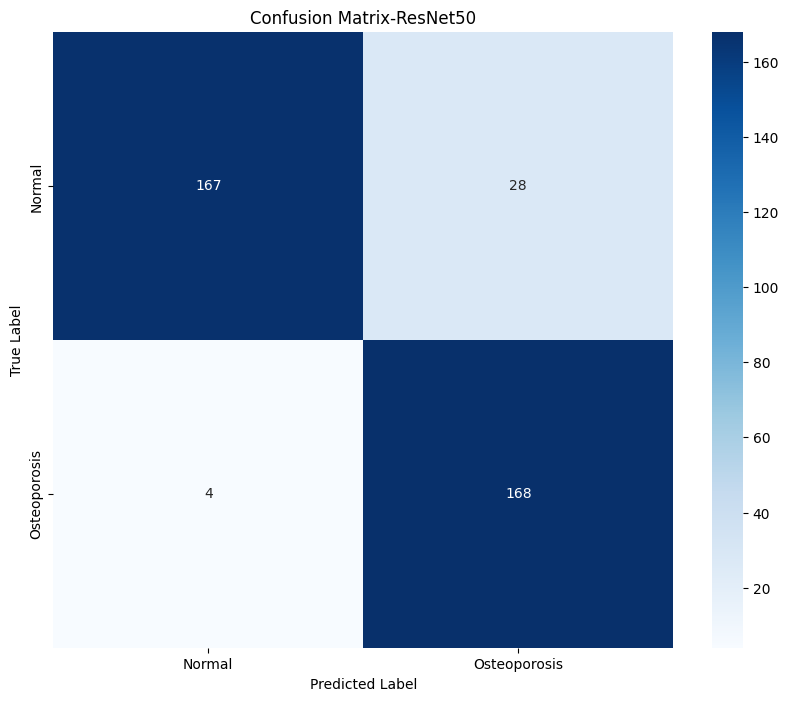

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_r = confusion_matrix(y_true, y_pred_classes_r)
sns.heatmap(cm_r, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix-ResNet50')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-ResNet50:")
print(classification_report(y_true, y_pred_classes_r, target_names=class_names))


Classification Report-ResNet50:
              precision    recall  f1-score   support

      Normal       0.98      0.86      0.91       195
Osteoporosis       0.86      0.98      0.91       172

    accuracy                           0.91       367
   macro avg       0.92      0.92      0.91       367
weighted avg       0.92      0.91      0.91       367



In [ ]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
f1= f1_score(y_true, y_pred_classes_r)
acc= accuracy_score(y_true, y_pred_classes_r)
precision= precision_score(y_true, y_pred_classes_r)
recall= recall_score(y_true, y_pred_classes_r)

In [ ]:
print("F1 Score: ", f1)
print("Accuracy: ", acc)
print("Precision: ", precision)
print("Recall: ", recall)

F1 Score:  0.9130434782608695
Accuracy:  0.9128065395095368
Precision:  0.8571428571428571
Recall:  0.9767441860465116


In [ ]:
basemodel4 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

In [ ]:
# Freeze base model layers
basemodel4.trainable = False

In [ ]:
# #customize or finetune the VGG19 model
# x = basemodel4.output
# x = GlobalAveragePooling2D()(x)  # Reduce dimensions
# x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = BatchNormalization()(x)  # Added Batch Normalization
# x = Dropout(0.5)(x)
# x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)
# output = Dense(1, activation="sigmoid")(x)

In [ ]:
x = basemodel4.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
# modelbv19 = Model(inputs=basemodel4.input, outputs=output)

In [ ]:
model2 = Model(inputs=basemodel4.input, outputs=output)

In [ ]:
# Unfreeze the last 50 layers for fine-tuning
for layer in basemodel4.layers[-50:]:
    layer.trainable = True

In [ ]:
# Compile model
model2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,637,313 (93.98 MB)

 Trainable params: 18,000,129 (68.67 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [ ]:
# Train the model
historybr1 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.5824 - loss: 0.7359 - val_accuracy: 0.5041 - val_loss: 0.7006
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 596ms/step - accuracy: 0.6824 - loss: 0.6510 - val_accuracy: 0.6230 - val_loss: 0.6712
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 583ms/step - accuracy: 0.6575 - loss: 0.6003 - val_accuracy: 0.5041 - val_loss: 0.6429
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 599ms/step - accuracy: 0.6929 - loss: 0.5918 - val_accuracy: 0.5164 - val_loss: 0.6210
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 588ms/step - accuracy: 0.6782 - loss: 0.6057 - val_accuracy: 0.5164 - val_loss: 0.7801


In [ ]:
# Evaluate the model
loss, accuracy = model2.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 0.5032 - loss: 0.8105
Validation Accuracy: 0.52


In [ ]:
# Train the model
historybr2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 623ms/step - accuracy: 0.6485 - loss: 0.6279 - val_accuracy: 0.5041 - val_loss: 1.5985
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 642ms/step - accuracy: 0.7141 - loss: 0.5874 - val_accuracy: 0.5041 - val_loss: 1.8106
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 593ms/step - accuracy: 0.7210 - loss: 0.5610 - val_accuracy: 0.5041 - val_loss: 0.9516
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 590ms/step - accuracy: 0.6975 - loss: 0.5850 - val_accuracy: 0.5041 - val_loss: 1.2030
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 594ms/step - accuracy: 0.7198 - loss: 0.5711 - val_accuracy: 0.5369 - val_loss: 0.7143


In [ ]:
# Evaluate the model
loss, accuracy = model2.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - accuracy: 0.5149 - loss: 0.7274
Validation Accuracy: 0.54


In [ ]:
# Train the model
historybr2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 653ms/step - accuracy: 0.6970 - loss: 0.5706 - val_accuracy: 0.4918 - val_loss: 0.8755
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 601ms/step - accuracy: 0.7189 - loss: 0.5764 - val_accuracy: 0.7582 - val_loss: 0.5367
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 573ms/step - accuracy: 0.7288 - loss: 0.5411 - val_accuracy: 0.7090 - val_loss: 0.5510
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 588ms/step - accuracy: 0.7316 - loss: 0.5524 - val_accuracy: 0.7295 - val_loss: 0.5362
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 604ms/step - accuracy: 0.7009 - loss: 0.5534 - val_accuracy: 0.5410 - val_loss: 0.8888


In [ ]:
# Evaluate the model
loss, accuracy = model2.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.5142 - loss: 0.9421
Validation Accuracy: 0.54


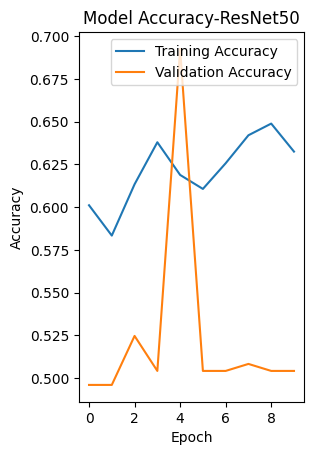

In [ ]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(historybr1.history['accuracy'], label='Training Accuracy')
plt.plot(historybr1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy-ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

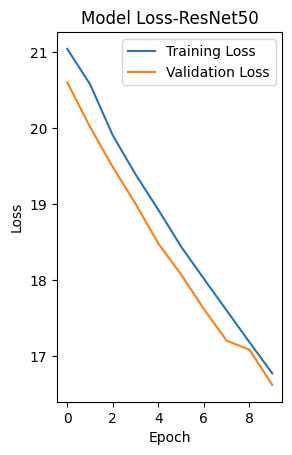

In [ ]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(historybr1.history['loss'], label='Training Loss')
plt.plot(historybr1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss-ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Evaluation on Validation Data
# Predict on validation data
y_pred_r = model2.predict(test_generator)
y_pred_classes_r = np.argmax(y_pred_r, axis=1)
y_true = test_generator.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


In [ ]:
# Evaluate the model
loss, accuracy = model2.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 651ms/step - accuracy: 0.2307 - loss: 20.7417
Test Accuracy: 0.50


Text(95.72222222222221, 0.5, 'True Label')

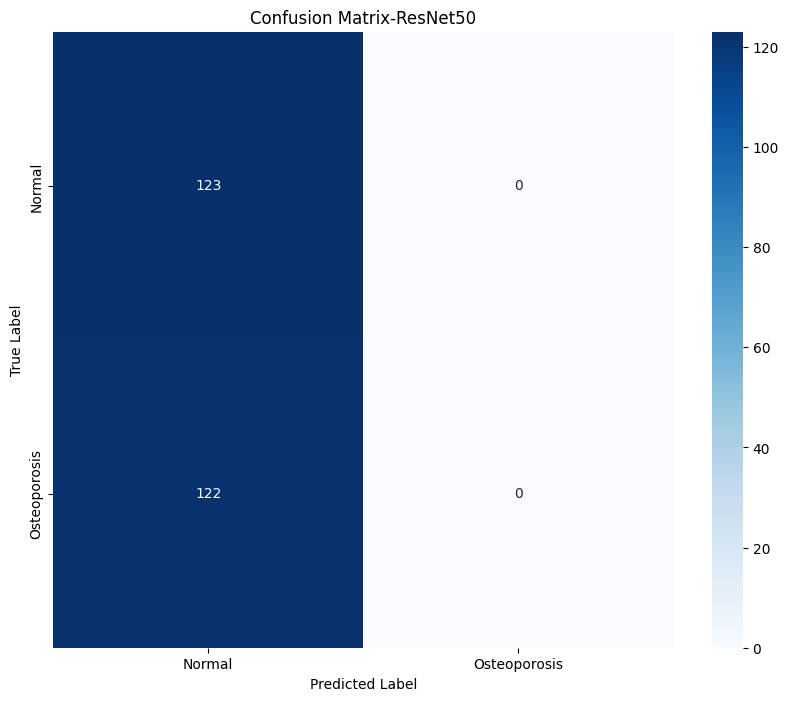

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_r = confusion_matrix(y_true, y_pred_classes_r)
sns.heatmap(cm_r, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix-ResNet50')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_r, target_names=class_names))


Classification Report-VGG19:
              precision    recall  f1-score   support

      Normal       0.50      1.00      0.67       123
Osteoporosis       0.00      0.00      0.00       122

    accuracy                           0.50       245
   macro avg       0.25      0.50      0.33       245
weighted avg       0.25      0.50      0.34       245



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#WithSAM

In [ ]:
healthy_dirs = [r'drive/MyDrive/ROI/Normal']


osteoporosis_dirs = [r'drive/MyDrive/ROI/Osteoporosis']

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Normal', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())

                              filepaths  labels
0   drive/MyDrive/ROI/Normal/3 (1).jpeg  Normal
1      drive/MyDrive/ROI/Normal/22.jpeg  Normal
2  drive/MyDrive/ROI/Normal/31 (1).jpeg  Normal
3      drive/MyDrive/ROI/Normal/23.jpeg  Normal
4      drive/MyDrive/ROI/Normal/15.jpeg  Normal
labels
Normal          66
Osteoporosis    56
Name: count, dtype: int64


In [ ]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(97, 2)
(37, 2)
(25, 2)
(85, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 97 validated image filenames belonging to 2 classes.
Found 37 validated image filenames belonging to 2 classes.
Found 25 validated image filenames belonging to 2 classes.


####Image Generation and Augmentation

##DenseNet

In [ ]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Load DenseNet201 as the backbone
densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Freeze the initial layers
for layer in densenet_model.layers:
    layer.trainable = False

# Add custom layers
x = densenet_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model = Model(inputs=densenet_model.input, outputs=output)

# Unfreeze the last 50 layers for fine-tuning
for layer in densenet_model.layers[-50:]:
    layer.trainable = True

# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Add label smoothing
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 250, 250, 3)    │              0 │ input_layer_5[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 122, 122, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 122, 122, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 122, 122, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 124, 124, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 61, 61, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 61, 61, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 61, 61, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 61, 61, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 61, 61, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 61, 61, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 61, 61, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 20,821,058 (79.43 MB)

 Trainable params: 4,387,010 (16.74 MB)

 Non-trainable params: 16,434,048 (62.69 MB)

In [ ]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5213 - loss: 21.2733 - val_accuracy: 0.4800 - val_loss: 19.5332
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6708 - loss: 19.1793 - val_accuracy: 0.4000 - val_loss: 18.4252
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6716 - loss: 18.2331 - val_accuracy: 0.4400 - val_loss: 17.4214
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7756 - loss: 17.0373 - val_accuracy: 0.4400 - val_loss: 16.5379
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6979 - loss: 16.1479 - val_accuracy: 0.4000 - val_loss: 15.9041
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7565 - loss: 15.5020 - val_accuracy: 0.4000 - val_loss: 15.3972
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8973 - loss: 14.6510 - val_accuracy: 0.4400 - val_loss: 14.8328
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8400 - loss: 14.1361 - val_accuracy: 0.5

In [ ]:
model.evaluate(test, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 671ms/step - accuracy: 0.5409 - loss: 13.1538


[13.13884162902832, 0.5945945978164673]

In [ ]:
history2 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8264 - loss: 12.8480 - val_accuracy: 0.4400 - val_loss: 13.0805
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7281 - loss: 12.5996 - val_accuracy: 0.4800 - val_loss: 12.8678
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8572 - loss: 12.1899 - val_accuracy: 0.4400 - val_loss: 12.7851
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7920 - loss: 11.9927 - val_accuracy: 0.4400 - val_loss: 12.7719
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7971 - loss: 11.9059 - val_accuracy: 0.5200 - val_loss: 12.4012
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8618 - loss: 11.6985 - val_accuracy: 0.5200 - val_loss: 12.2780
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8862 - loss: 11.4673 - val_accuracy: 0.6000 - val_loss: 11.9788
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7988 - loss: 11.3342 - val_accuracy: 0.6

In [ ]:
model.evaluate(test, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 678ms/step - accuracy: 0.5490 - loss: 11.6996


[11.656609535217285, 0.5675675868988037]

In [ ]:
history3 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8662 - loss: 10.9391 - val_accuracy: 0.6000 - val_loss: 11.3754
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9751 - loss: 10.6664 - val_accuracy: 0.6800 - val_loss: 11.3130
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7983 - loss: 10.7973 - val_accuracy: 0.5600 - val_loss: 11.1600
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9055 - loss: 10.6016 - val_accuracy: 0.7600 - val_loss: 10.8363
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8802 - loss: 10.6106 - val_accuracy: 0.8800 - val_loss: 10.8146
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9594 - loss: 10.3363 - val_accuracy: 0.8400 - val_loss: 10.7037
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8236 - loss: 10.5055 - val_accuracy: 0.7600 - val_loss: 10.7282
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7542 - loss: 10.4973 - val_accur

In [ ]:
model.evaluate(test, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8514 - loss: 10.3572


[10.399231910705566, 0.837837815284729]

In [ ]:
history4 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8839 - loss: 10.0814 - val_accuracy: 0.8800 - val_loss: 10.4071
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8346 - loss: 10.0558 - val_accuracy: 0.8800 - val_loss: 10.3194
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8979 - loss: 9.9463 - val_accuracy: 0.9200 - val_loss: 10.2256
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9627 - loss: 9.8157 - val_accuracy: 0.7600 - val_loss: 10.1615
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9517 - loss: 9.7714 - val_accuracy: 0.7200 - val_loss: 10.2069
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9040 - loss: 9.8112 - val_accuracy: 0.7600 - val_loss: 9.9598
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8677 - loss: 9.7951 - val_accuracy: 0.7200 - val_loss: 10.0510
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9478 - loss: 9.6354 - val_accuracy: 0.

In [ ]:
model.evaluate(test, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7722 - loss: 9.7355


[9.708910942077637, 0.837837815284729]

In [ ]:
history5 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7880 - loss: 9.8393 - val_accuracy: 0.6400 - val_loss: 10.1085
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8551 - loss: 9.5432 - val_accuracy: 0.7600 - val_loss: 9.9047
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9193 - loss: 9.4439 - val_accuracy: 0.7600 - val_loss: 9.7763
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8823 - loss: 9.3663 - val_accuracy: 0.6800 - val_loss: 9.6923
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9591 - loss: 9.2498 - val_accuracy: 0.7200 - val_loss: 9.6572
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8628 - loss: 9.3278 - val_accuracy: 0.7600 - val_loss: 9.6683
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9281 - loss: 9.2541 - val_accuracy: 0.7200 - val_loss: 9.6660
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9201 - loss: 9.2417 - val_accuracy: 0.7600 - 

In [ ]:
model.evaluate(test, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7722 - loss: 9.4255


[9.305824279785156, 0.837837815284729]

In [ ]:
# Predict on validation data
y_pred_d = model.predict(test)
y_pred_classes_d = np.argmax(y_pred_d, axis=1)
y_true = test.classes

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Text(95.72222222222221, 0.5, 'True Label')

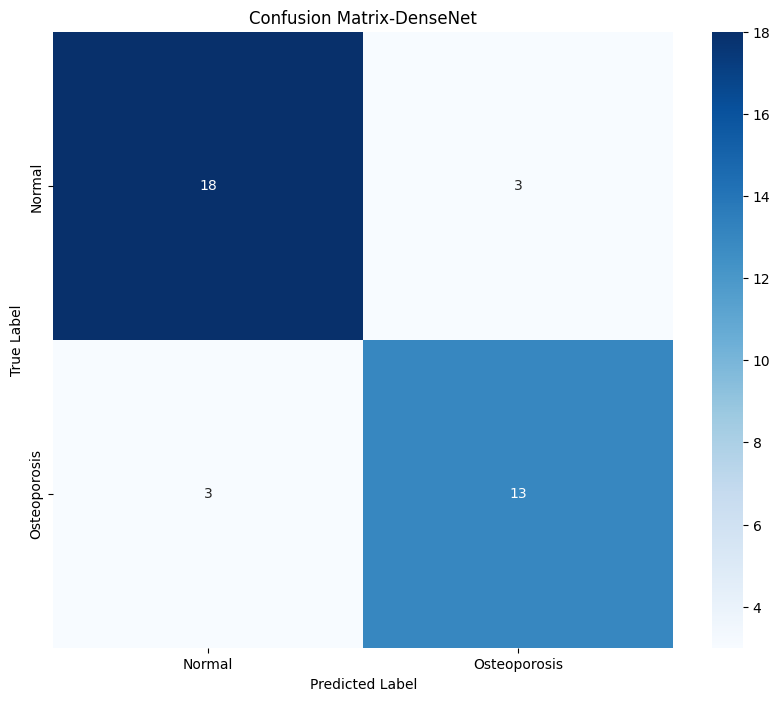

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_d = confusion_matrix(y_true, y_pred_classes_d)
sns.heatmap(cm_d, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix-DenseNet')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_d, target_names=class_names))


Classification Report-VGG19:
              precision    recall  f1-score   support

      Normal       0.86      0.86      0.86        21
Osteoporosis       0.81      0.81      0.81        16

    accuracy                           0.84        37
   macro avg       0.83      0.83      0.83        37
weighted avg       0.84      0.84      0.84        37



In [ ]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
f1= f1_score(y_true, y_pred_classes_d)
acc= accuracy_score(y_true, y_pred_classes_d)
precision= precision_score(y_true, y_pred_classes_d)
recall= recall_score(y_true, y_pred_classes_d)

##VGG

In [ ]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Load DenseNet201 as the backbone
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Freeze the initial layers
for layer in vgg_model.layers:
    layer.trainable = False

# Add custom layers
x = vgg_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model2 = Model(inputs=vgg_model.input, outputs=output)

# Unfreeze the last 50 layers for fine-tuning
for layer in densenet_model.layers[-50:]:
    layer.trainable = True

# Compile the model
model2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Add label smoothing
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 244, 244, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 244, 244, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 122, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 122, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 61, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,081,666 (80.42 MB)

 Trainable params: 1,054,210 (4.02 MB)

 Non-trainable params: 20,027,456 (76.40 MB)

In [ ]:
historyv = model2.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.4416 - loss: 14.6057 - val_accuracy: 0.6400 - val_loss: 13.4669
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.5081 - loss: 13.9394 - val_accuracy: 0.4400 - val_loss: 12.7624
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5746 - loss: 12.8882 - val_accuracy: 0.3600 - val_loss: 12.1570
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6665 - loss: 12.1871 - val_accuracy: 0.3600 - val_loss: 11.6174
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5449 - loss: 12.0841 - val_accuracy: 0.3600 - val_loss: 11.1313
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.5951 - loss: 11.3605 - val_accuracy: 0.3600 - val_loss: 10.6626
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7399 - loss: 10.4444 - val_accuracy: 0.3600 - val_loss: 10.3231
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.7051 - loss: 10.2056 - val_accuracy: 0.3600 - val_l

In [ ]:
model2.evaluate(test, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.3488 - loss: 9.3663


[9.292415618896484, 0.4324324429035187]

In [ ]:
# Predict on validation data
y_pred_v = model2.predict(test)
y_pred_classes_v = np.argmax(y_pred_v, axis=1)
y_true = test.classes

10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


Text(95.72222222222221, 0.5, 'True Label')

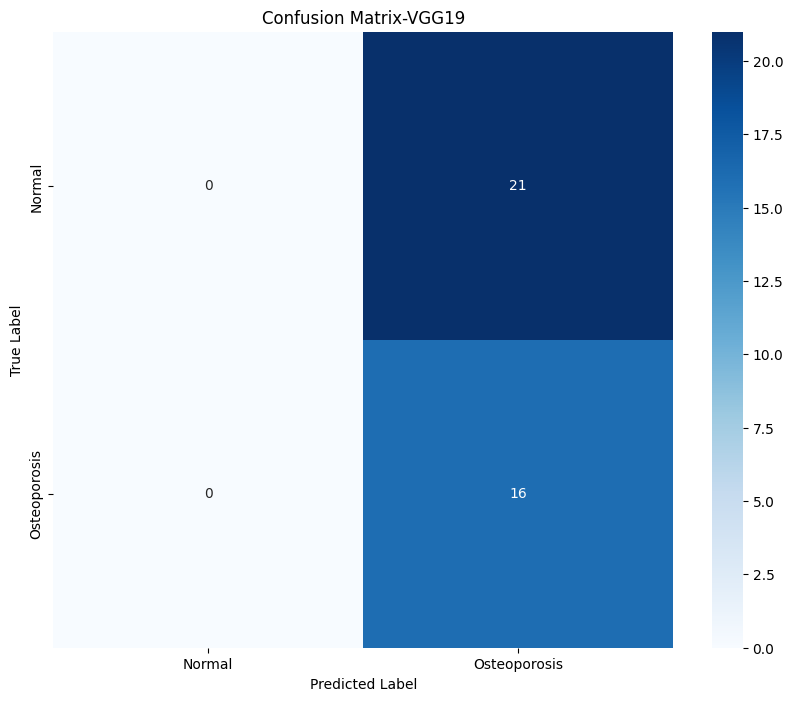

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_v = confusion_matrix(y_true, y_pred_classes_v)
sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix-VGG19')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_v, target_names=class_labels))


Classification Report-VGG19:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00        21
Osteoporosis       0.43      1.00      0.60        16

    accuracy                           0.43        37
   macro avg       0.22      0.50      0.30        37
weighted avg       0.19      0.43      0.26        37



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
f1= f1_score(y_true, y_pred_classes_v)
acc= accuracy_score(y_true, y_pred_classes_v)
precision= precision_score(y_true, y_pred_classes_v)
recall= recall_score(y_true, y_pred_classes_v)

In [ ]:
print("F1",f1)
print("Accuracy",acc)
print("Precision",precision)
print("Recall",recall)

F1 0.6037735849056604
Accuracy 0.43243243243243246
Precision 0.43243243243243246
Recall 1.0


##ResNet

In [ ]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Load DenseNet201 as the backbone
res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Freeze the initial layers
for layer in vgg_model.layers:
    layer.trainable = False

# Add custom layers
x = res_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model3 = Model(inputs=res_model.input, outputs=output)

# Unfreeze the last 50 layers for fine-tuning
for layer in densenet_model.layers[-50:]:
    layer.trainable = True

# Compile the model
model3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Add label smoothing
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model3.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 250, 250, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 122, 122, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 122, 122, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 122, 122, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 124, 124, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 61, 61, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 61, 61, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 61, 61, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 61, 61, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 61, 61, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 61, 61, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 61, 61, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,217,858 (100.01 MB)

 Trainable params: 26,161,666 (99.80 MB)

 Non-trainable params: 56,192 (219.50 KB)

In [ ]:
# Train the model
historybr1 = model3.fit(train,validation_data=val,epochs=10,verbose=1)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.6245 - loss: 18.9983 - val_accuracy: 0.6400 - val_loss: 18.5766
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8101 - loss: 18.5645 - val_accuracy: 0.6400 - val_loss: 18.4692
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.7259 - loss: 18.7467 - val_accuracy: 0.6400 - val_loss: 18.4180
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.7006 - loss: 18.3849 - val_accuracy: 0.6400 - val_loss: 18.2791
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7923 - loss: 18.2268 - val_accuracy: 0.6400 - val_loss: 18.3817
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.7331 - loss: 18.0335 - val_accuracy: 0.6400 - val_loss: 18.5117
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7829 - loss: 17.9073 - val_accuracy: 0.6400 - val_loss: 18.4232
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.7973 - loss: 17.8402 - val_accuracy: 0.6

In [ ]:
model3.evaluate(test, verbose=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 597ms/step - accuracy: 0.5036 - loss: 18.7176


[18.7349853515625, 0.45945945382118225]

In [ ]:
# Predict on validation data
y_pred_r = model3.predict(test)
y_pred_classes_r = np.argmax(y_pred_r, axis=1)
y_true = test.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


Text(95.72222222222221, 0.5, 'True Label')

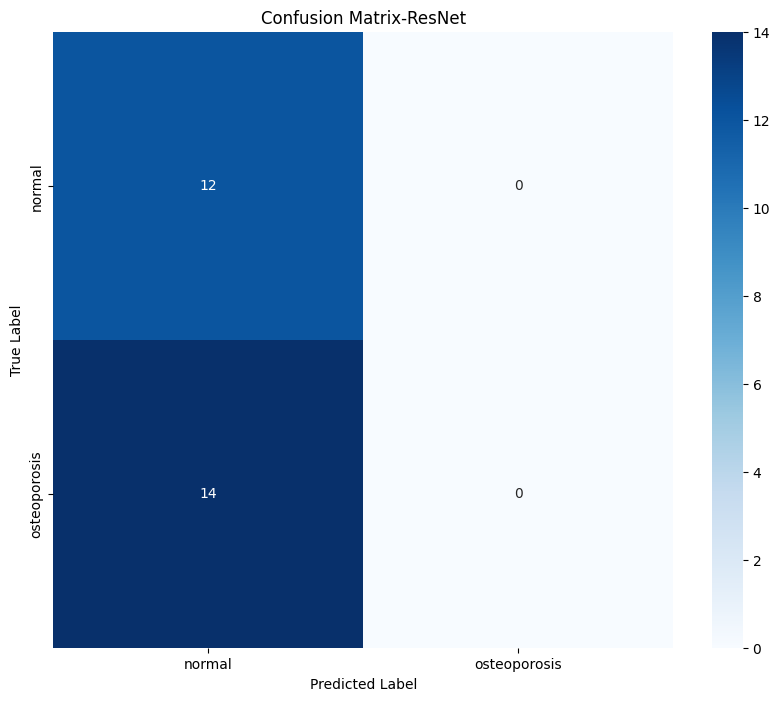

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_r = confusion_matrix(y_true, y_pred_classes_r)
sns.heatmap(cm_r, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix-ResNet')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_r, target_names=class_labels))


Classification Report-VGG19:
              precision    recall  f1-score   support

      normal       0.46      1.00      0.63        12
osteoporosis       0.00      0.00      0.00        14

    accuracy                           0.46        26
   macro avg       0.23      0.50      0.32        26
weighted avg       0.21      0.46      0.29        26



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
f1= f1_score(y_true, y_pred_classes_r)
acc= accuracy_score(y_true, y_pred_classes_r)
precision= precision_score(y_true, y_pred_classes_r)
recall= recall_score(y_true, y_pred_classes_r)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("F1",f1)
print("Accuracy",acc)
print("Precision",precision)
print("Recall",recall)

F1 0.0
Accuracy 0.46153846153846156
Precision 0.0
Recall 0.0


#Without SAM (First Dataset)

In [ ]:
healthy_dirs = [r'drive/MyDrive/osteoporosis_knee_x-ray/normal']


osteoporosis_dirs = [r'drive/MyDrive/osteoporosis_knee_x-ray/osteoporosis']

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['normal', 'osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())

                                           filepaths  labels
0  drive/MyDrive/osteoporosis_knee_x-ray/normal/N...  normal
1  drive/MyDrive/osteoporosis_knee_x-ray/normal/N...  normal
2  drive/MyDrive/osteoporosis_knee_x-ray/normal/N...  normal
3  drive/MyDrive/osteoporosis_knee_x-ray/normal/N...  normal
4  drive/MyDrive/osteoporosis_knee_x-ray/normal/N...  normal
labels
osteoporosis    49
normal          36
Name: count, dtype: int64


In [ ]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [ ]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(68, 2)
(26, 2)
(17, 2)
(59, 2)


In [ ]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 68 validated image filenames belonging to 2 classes.
Found 26 validated image filenames belonging to 2 classes.
Found 17 validated image filenames belonging to 2 classes.


In [ ]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Load DenseNet201 as the backbone
densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Freeze the initial layers
for layer in densenet_model.layers:
    layer.trainable = False

# Add custom layers
x = densenet_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model = Model(inputs=densenet_model.input, outputs=output)

# Unfreeze the last 50 layers for fine-tuning
for layer in densenet_model.layers[-50:]:
    layer.trainable = True

# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Add label smoothing
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 244, 244, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 250, 250, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 122, 122, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 122, 122, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 122, 122, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 124, 124, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 61, 61, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 61, 61, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 61, 61, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 61, 61, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 61, 61, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 61, 61, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 61, 61, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 20,821,058 (79.43 MB)

 Trainable params: 4,387,010 (16.74 MB)

 Non-trainable params: 16,434,048 (62.69 MB)

In [ ]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5137 - loss: 20.9569 - val_accuracy: 0.5882 - val_loss: 19.8680
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.6064 - loss: 19.7853 - val_accuracy: 0.6471 - val_loss: 18.9872
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6203 - loss: 18.9178 - val_accuracy: 0.5294 - val_loss: 18.1924
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7939 - loss: 17.8807 - val_accuracy: 0.5882 - val_loss: 17.5111
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6333 - loss: 17.3874 - val_accuracy: 0.5294 - val_loss: 16.9375
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8852 - loss: 16.5329 - val_accuracy: 0.5882 - val_loss: 16.3423
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8245 - loss: 15.9771 - val_accuracy: 0.4706 - val_loss: 15.8311
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7535 - loss: 15.8184 - val_accuracy: 0.4706 - val_l

In [ ]:
model.evaluate(test, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 709ms/step - accuracy: 0.6465 - loss: 14.5196


[14.458537101745605, 0.692307710647583]

In [ ]:
# Predict on validation data
y_pred_d = model.predict(test)
y_pred_classes_d = np.argmax(y_pred_d, axis=1)
y_true = test.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


Text(95.72222222222221, 0.5, 'True Label')

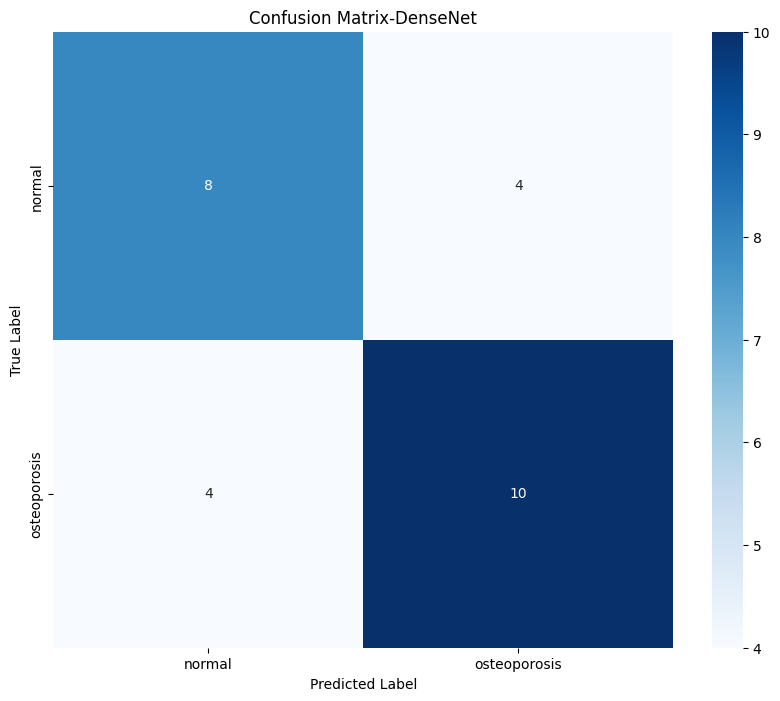

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_d = confusion_matrix(y_true, y_pred_classes_d)
sns.heatmap(cm_d, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix-DenseNet')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_d, target_names=class_labels))


Classification Report-VGG19:
              precision    recall  f1-score   support

      normal       0.67      0.67      0.67        12
osteoporosis       0.71      0.71      0.71        14

    accuracy                           0.69        26
   macro avg       0.69      0.69      0.69        26
weighted avg       0.69      0.69      0.69        26



In [ ]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
f1= f1_score(y_true, y_pred_classes_d)
acc= accuracy_score(y_true, y_pred_classes_d)
precision= precision_score(y_true, y_pred_classes_d)
recall= recall_score(y_true, y_pred_classes_d)

In [ ]:
print("F1",f1)
print("Accuracy",acc)
print("Precision",precision)
print("Recall",recall)

F1 0.7142857142857143
Accuracy 0.6923076923076923
Precision 0.7142857142857143
Recall 0.7142857142857143


##VGG19

In [ ]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Load DenseNet201 as the backbone
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the initial layers
for layer in vgg_model.layers:
    layer.trainable = False

# Add custom layers
x = vgg_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model2 = Model(inputs=vgg_model.input, outputs=output)

# Unfreeze the last 50 layers for fine-tuning
for layer in densenet_model.layers[-50:]:
    layer.trainable = True

# Compile the model
model2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Add label smoothing
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model2.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 244, 244, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 244, 244, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 122, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 122, 122, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 61, 61, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 61, 61, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,081,666 (80.42 MB)

 Trainable params: 1,054,210 (4.02 MB)

 Non-trainable params: 20,027,456 (76.40 MB)

In [ ]:
historyv = model2.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step - accuracy: 0.4847 - loss: 14.5965 - val_accuracy: 0.4706 - val_loss: 13.7989
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.6299 - loss: 13.8906 - val_accuracy: 0.4706 - val_loss: 13.2928
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.4060 - loss: 13.6607 - val_accuracy: 0.4706 - val_loss: 12.8292
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.6198 - loss: 12.8708 - val_accuracy: 0.4706 - val_loss: 12.4059
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.6684 - loss: 12.4031 - val_accuracy: 0.3529 - val_loss: 12.0166
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.6823 - loss: 12.0891 - val_accuracy: 0.3529 - val_loss: 11.6511
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.6756 - loss: 11.5788 - val_accuracy: 0.3529 - val_loss: 11.3074
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.6550 - loss: 11.3662 - val_accuracy: 0.4

In [ ]:
model2.evaluate(test, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.3355 - loss: 10.4341


[10.421710968017578, 0.3461538553237915]

In [ ]:
# Predict on validation data
y_pred_v = model2.predict(test)
y_pred_classes_v = np.argmax(y_pred_v, axis=1)
y_true = test.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step


Text(95.72222222222221, 0.5, 'True Label')

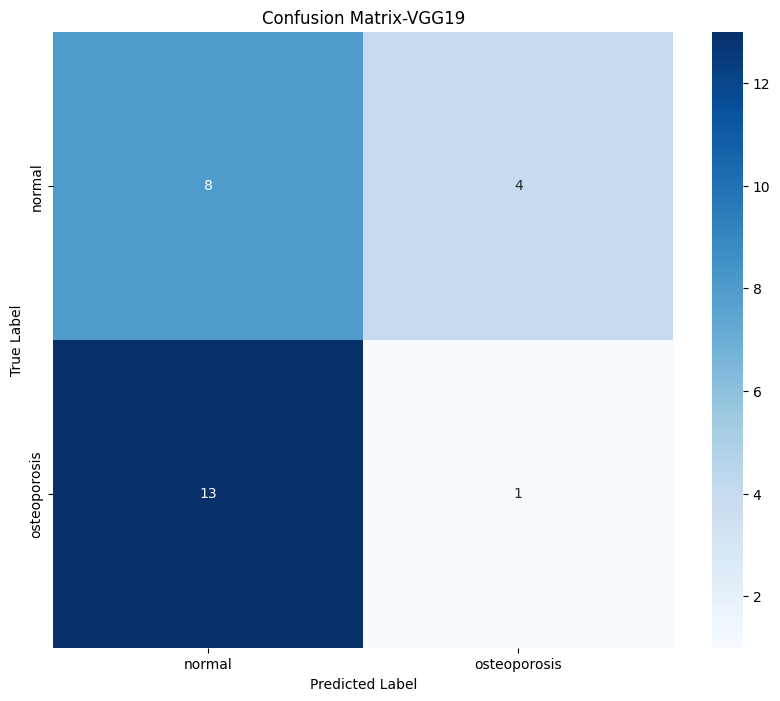

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_v = confusion_matrix(y_true, y_pred_classes_v)
sns.heatmap(cm_v, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix-VGG19')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_v, target_names=class_labels))


Classification Report-VGG19:
              precision    recall  f1-score   support

      normal       0.38      0.67      0.48        12
osteoporosis       0.20      0.07      0.11        14

    accuracy                           0.35        26
   macro avg       0.29      0.37      0.30        26
weighted avg       0.28      0.35      0.28        26



In [ ]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
f1= f1_score(y_true, y_pred_classes_v)
acc= accuracy_score(y_true, y_pred_classes_v)
precision= precision_score(y_true, y_pred_classes_v)
recall= recall_score(y_true, y_pred_classes_v)

In [ ]:
print("F1",f1)
print("Accuracy",acc)
print("Precision",precision)
print("Recall",recall)

F1 0.10526315789473684
Accuracy 0.34615384615384615
Precision 0.2
Recall 0.07142857142857142


##ResNet

In [ ]:
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Load DenseNet201 as the backbone
res_model = ResNet50(weights='imagenet', include_top=False, input_shape=(244, 244, 3))

# Freeze the initial layers
for layer in vgg_model.layers:
    layer.trainable = False

# Add custom layers
x = res_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions
x = Dense(1024, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)
x = Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output layer
output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model3 = Model(inputs=res_model.input, outputs=output)

# Unfreeze the last 50 layers for fine-tuning
for layer in densenet_model.layers[-50:]:
    layer.trainable = True

# Compile the model
model3.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Add label smoothing
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model3.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 244, 244, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 250, 250, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 122, 122, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 122, 122, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 122, 122, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 124, 124, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 61, 61, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 61, 61, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 61, 61, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 61, 61, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 61, 61, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 61, 61, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 61, 61, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 61, 61, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,217,858 (100.01 MB)

 Trainable params: 26,161,666 (99.80 MB)

 Non-trainable params: 56,192 (219.50 KB)

In [ ]:
# Train the model
historybr1 = model3.fit(train,validation_data=val,epochs=10,verbose=1)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.5526 - loss: 21.6244 - val_accuracy: 0.5294 - val_loss: 20.8500
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.6725 - loss: 20.8383 - val_accuracy: 0.5294 - val_loss: 20.6947
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.6640 - loss: 20.6018 - val_accuracy: 0.7059 - val_loss: 20.4288
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.6672 - loss: 20.5886 - val_accuracy: 0.5294 - val_loss: 20.3018
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.7371 - loss: 20.2088 - val_accuracy: 0.4118 - val_loss: 20.1866
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.7411 - loss: 20.1855 - val_accuracy: 0.4706 - val_loss: 20.3433
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7618 - loss: 19.9796 - val_accuracy: 0.4706 - val_loss: 20.3456
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.7187 - loss: 19.9904 - val_accuracy: 0.

In [ ]:
model3.evaluate(test, verbose=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 754ms/step - accuracy: 0.4805 - loss: 20.2444


[20.259225845336914, 0.4615384638309479]

In [ ]:
# Predict on validation data
y_pred_r = model3.predict(test)
y_pred_classes_r = np.argmax(y_pred_r, axis=1)
y_true = test.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


Text(95.72222222222221, 0.5, 'True Label')

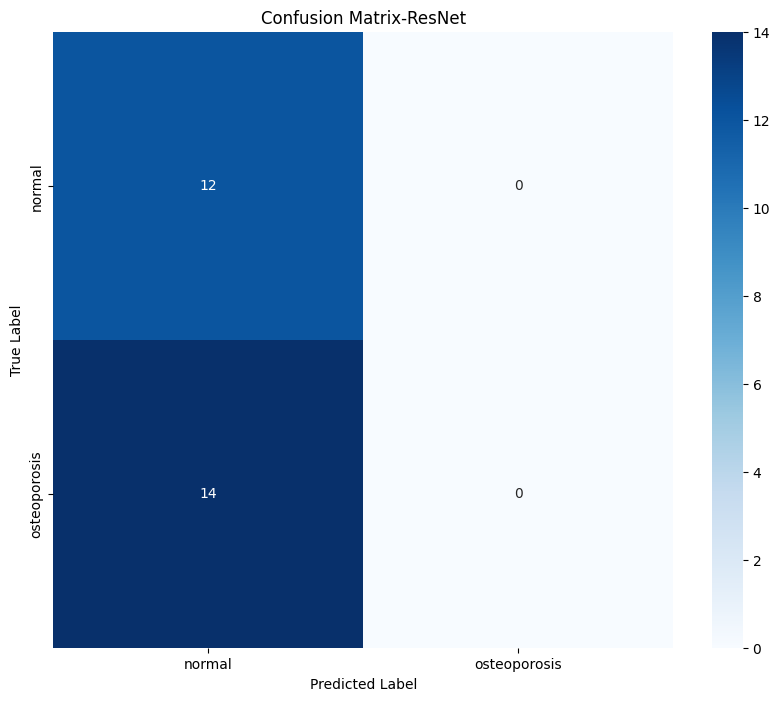

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_r = confusion_matrix(y_true, y_pred_classes_r)
sns.heatmap(cm_r, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix-ResNet')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# plt.tight_layout()
# plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'))
# plt.close()

In [ ]:
# Classification Report
print("\nClassification Report-VGG19:")
print(classification_report(y_true, y_pred_classes_r, target_names=class_labels))


Classification Report-VGG19:
              precision    recall  f1-score   support

      normal       0.46      1.00      0.63        12
osteoporosis       0.00      0.00      0.00        14

    accuracy                           0.46        26
   macro avg       0.23      0.50      0.32        26
weighted avg       0.21      0.46      0.29        26



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score, classification_report,precision_score, recall_score,confusion_matrix,ConfusionMatrixDisplay,f1_score
f1= f1_score(y_true, y_pred_classes_r)
acc= accuracy_score(y_true, y_pred_classes_r)
precision= precision_score(y_true, y_pred_classes_r)
recall= recall_score(y_true, y_pred_classes_r)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("F1",f1)
print("Accuracy",acc)
print("Precision",precision)
print("Recall",recall)

F1 0.0
Accuracy 0.46153846153846156
Precision 0.0
Recall 0.0
